<a href="https://colab.research.google.com/github/luthfior/HoaxDetectionApp/blob/main/Salinan_dari_skrips_luthfi_hoax_detection_svm_gb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nlp-id
!pip install numpy==1.23.5 scikit-learn==1.2.2 imbalanced-learn==0.10.1

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 402.6/402.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 25.5 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=978a4a3a58b25bd33dbd525954e4c82df839e92444585a8b248b435300591098
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.23.5
    Uninstalling huggingface-hub-0.23.5:
      Successfully uninstalled huggingface-hub-0.23.5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 39.4 MB/s eta 0:00:00
   

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import string
import re
import json
import pickle
import matplotlib.pyplot as plt
from dateutil import parser
from datetime import datetime
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from nlp_id.lemmatizer import Lemmatizer
from nlp_id.tokenizer import Tokenizer
from nlp_id.tokenizer import PhraseTokenizer
from nlp_id.stopword import StopWord
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/ta_deteksi_hoax/dataset_fact_hoax_ikn4.csv")

Jumlah nilai yang hilang di setiap kolom:
judul_berita       0
tanggal_posting    0
sumber             0
url                0
label              0
dtype: int64


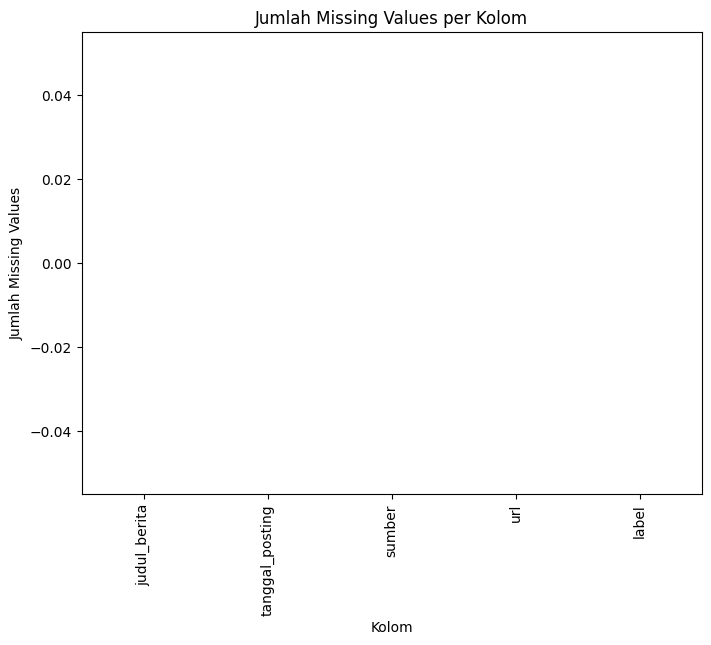

In [ ]:
# Hitung jumlah baris awal
initial_count = data.shape[0]

# Cek data yang kosong atau null
missing_values = data.isnull().sum()
print("Jumlah nilai yang hilang di setiap kolom:")
print(missing_values)

plt.figure(figsize=(8, 6))
missing_values.plot(kind='bar')
plt.title('Jumlah Missing Values per Kolom')
plt.xlabel('Kolom')
plt.ylabel('Jumlah Missing Values')
plt.show()

Jumlah baris duplikat berdasarkan kolom 'judul_berita': 0


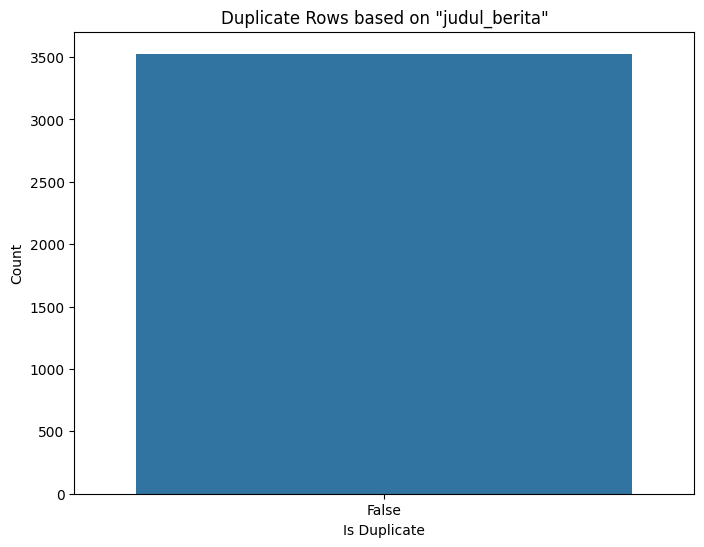

Data yang duplikat:
Empty DataFrame
Columns: [judul_berita, tanggal_posting, sumber, url, label]
Index: []


In [ ]:
# Mengecek duplikasi berdasarkan kolom 'judul_berita'
duplicate_rows = data.duplicated(subset=['judul_berita'])
num_duplicates = duplicate_rows.sum()
print(f"Jumlah baris duplikat berdasarkan kolom 'judul_berita': {num_duplicates}")

# Plot duplikat
plt.figure(figsize=(8, 6))
sns.countplot(x=duplicate_rows)
plt.title('Duplicate Rows based on "judul_berita"')
plt.xlabel('Is Duplicate')
plt.ylabel('Count')
plt.show()

# Tampilkan data yang duplikat
duplicate_data = data[duplicate_rows]
print("Data yang duplikat:")
print(duplicate_data)

Jumlah Berita Hoax per Tahun:
tanggal_posting
2021    216
2022    247
2023    452
2024    496
Name: count, dtype: int64


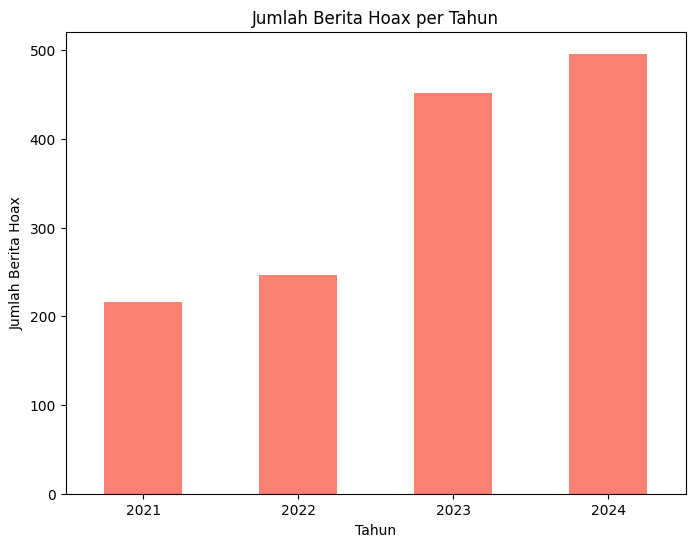

         tanggal_posting
2116         04 Jun 2024
2117         30 Jan 2024
2118         31 Aug 2023
2119         12 May 2023
2120  Jumat, 25 Feb 2022


In [ ]:
data['tanggal_posting'] = data['tanggal_posting'].astype(str)

def extract_year(date_str):
    match = re.search(r'20\d{2}', date_str)
    if match:
        return int(match.group(0))
    return None

# Filter berita hoax
hoax_data = data.loc[data['label'] == 1]

# Hitung jumlah berita hoax per tahun
berita_hoax_per_tahun = hoax_data['tanggal_posting'].apply(extract_year).value_counts().sort_index()

print("Jumlah Berita Hoax per Tahun:")
print(berita_hoax_per_tahun)

# Tampilkan plot jumlah berita hoax per tahun
plt.figure(figsize=(8, 6))
berita_hoax_per_tahun.plot(kind='bar', color='salmon')
plt.title('Jumlah Berita Hoax per Tahun')
plt.xlabel('Tahun')
plt.ylabel('Jumlah Berita Hoax')
plt.xticks(rotation=0)
plt.show()

print(hoax_data[['tanggal_posting']].head())

In [ ]:
# Filter data label = 0 adalah berita valid
true = data.loc[data['label'] == 0]

# Filter data label = 1 adalah berita hoax
fake = data.loc[data['label'] == 1]

# Tampilkan lima baris terakhir dari data valid
display(true.head())

# Tampilkan lima baris terakhir dari data hoax
display(fake.tail())

,judul_berita,tanggal_posting,sumber,url,label
0,Baleg DPR Sebut Presiden Ingin Pembahasan RUU ...,"Rabu, 24 Mar 2021 14:02 WIB",Eva Safitri - detikNews,https://news.detik.com/berita/d-5505766/baleg-...,0
1,Asa Rakyat Bumi Etam di Balik Pemindahan IKN,"Selasa, 11 Jan 2022 18:16 WIB",Mahyudin - detikNews,https://news.detik.com/kolom/d-5893663/asa-rak...,0
2,Prabowo Bahas Pertahanan IKN Nusantara di Rapi...,"Kamis, 20 Jan 2022 15:49 WIB",Rakha Arlyanto Darmawan - detikNews,https://news.detik.com/berita/d-5906926/prabow...,0
3,Kepala BIN: Berpindahnya IKN Akan Jadi Sejarah...,"Sabtu, 05 Feb 2022 19:27 WIB",Atta Kharisma - detikNews,https://news.detik.com/berita/d-5929558/kepala...,0
4,Stafsus Mensesneg: Ide IKN Baru Pikiran Jokowi...,"Jumat, 28 Jan 2022 15:21 WIB",Kanavino Ahmad Rizqo - detikNews,https://news.detik.com/berita/d-5918699/stafsu...,0


,judul_berita,tanggal_posting,sumber,url,label
3522,JOKOWI OBRAL IKN 190 TAHUN UNTUK ASING,"Juli 16, 2024",Tim Kalimasada - turnbackhoax,https://turnbackhoax.id/2024/07/16/salah-jokow...,1
3523,Jokowi Bangun IKN untuk Rakyat Tiongkok,"Juni 26, 2024",Tim Kalimasada - turnbackhoax,https://turnbackhoax.id/2024/06/26/salah-jokow...,1
3524,"Dulu Dana Haji Dipakai Infrastruktur, Sekarang...","Juni 21, 2024",Pemeriksa Fakta Junior - turnbackhoax,https://turnbackhoax.id/2024/06/21/salah-dulu-...,1
3525,KPK Bongkar Dana Tapera Digelapkan untuk IKN,"Juni 12, 2024",Pemeriksa Fakta Junior - turnbackhoax,https://turnbackhoax.id/2024/06/12/salah-kpk-b...,1
3526,“Menag minta masyarakat iklaskan Dana Haji dip...,"Juni 9, 2024",Tim Kalimasada - turnbackhoax,https://turnbackhoax.id/2024/06/09/salah-menag...,1


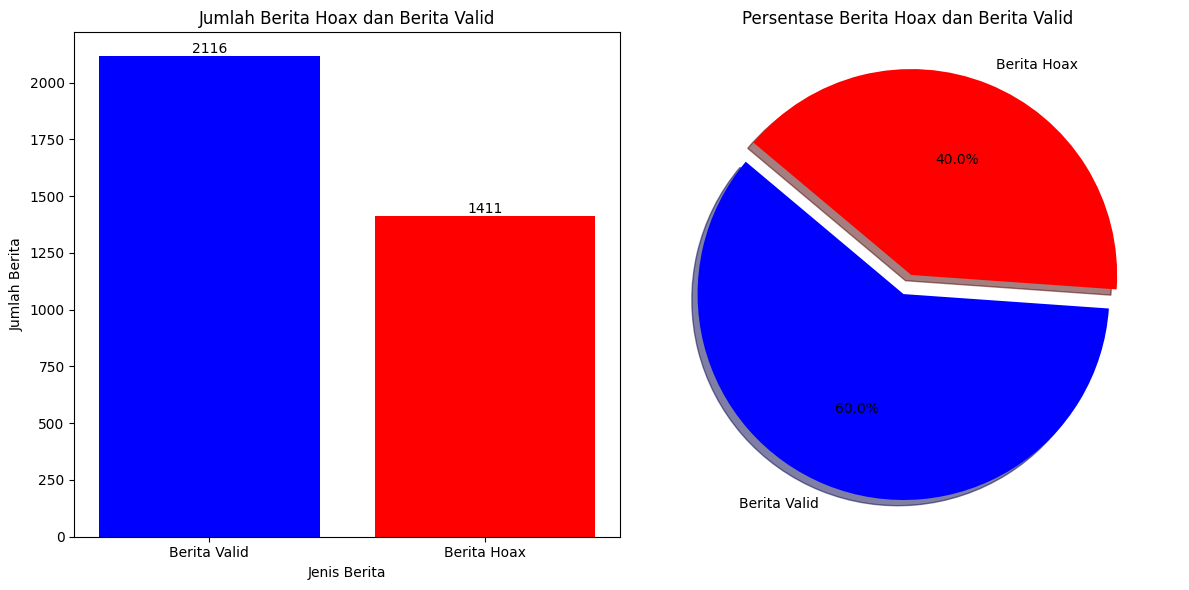

In [ ]:
# Hitung jumlah berita dalam setiap kelompok
count_true = true.shape[0]
count_fake = fake.shape[0]

# Membuat figure dan subplot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 baris, 2 kolom

# Plot jumlah berita hoax dan fakta (Diagram Batang)
axs[0].bar(['Berita Valid', 'Berita Hoax'], [count_true, count_fake], color=['blue', 'red'])
axs[0].set_title('Jumlah Berita Hoax dan Berita Valid')
axs[0].set_xlabel('Jenis Berita')
axs[0].set_ylabel('Jumlah Berita')

# Menambahkan angka di atas diagram batang
for bar in axs[0].patches:
    yval = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

# Plot persentase berita hoax dan fakta (Diagram Lingkaran)
labels = ['Berita Valid', 'Berita Hoax']
sizes = [count_true, count_fake]
colors = ['blue', 'red']
explode = (0.1, 0)  # Meledakkan potongan pertama (Berita Valid)

axs[1].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
axs[1].set_title('Persentase Berita Hoax dan Berita Valid')
axs[1].axis('equal')  # Memastikan pie chart berbentuk lingkaran

plt.tight_layout()  # Mengatur layout subplot agar rapi
plt.show()

In [ ]:
print(data.describe(include='O'))

                                             judul_berita tanggal_posting  \
count                                                3527            3527   
unique                                               3527            2764   
top     Baleg DPR Sebut Presiden Ingin Pembahasan RUU ...    Mei 31, 2024   
freq                                                    1              31   

                                       sumber  \
count                                    3527   
unique                                    330   
top     Pemeriksa Fakta Junior - turnbackhoax   
freq                                      802   

                                                      url  
count                                                3527  
unique                                               3509  
top     https://turnbackhoax.id/2024/06/30/salah-100-p...  
freq                                                    3  


In [ ]:
# Menghapus kolom yang tidak diperlukan tanpa inplace=True
data = data.drop(columns=['tanggal_posting', 'sumber', 'url'])

# Menyimpan DataFrame yang telah diubah ke file CSV
data.to_csv('/content/drive/MyDrive/ta_deteksi_hoax/data_feature_selection3.csv', index=False)

# Menampilkan DataFrame yang telah diubah
print(data.head())


                                        judul_berita  label
0  Baleg DPR Sebut Presiden Ingin Pembahasan RUU ...      0
1       Asa Rakyat Bumi Etam di Balik Pemindahan IKN      0
2  Prabowo Bahas Pertahanan IKN Nusantara di Rapi...      0
3  Kepala BIN: Berpindahnya IKN Akan Jadi Sejarah...      0
4  Stafsus Mensesneg: Ide IKN Baru Pikiran Jokowi...      0


In [ ]:
data

,judul_berita,label
0,Baleg DPR Sebut Presiden Ingin Pembahasan RUU ...,0
1,Asa Rakyat Bumi Etam di Balik Pemindahan IKN,0
2,Prabowo Bahas Pertahanan IKN Nusantara di Rapi...,0
3,Kepala BIN: Berpindahnya IKN Akan Jadi Sejarah...,0
4,Stafsus Mensesneg: Ide IKN Baru Pikiran Jokowi...,0
...,...,...
3522,JOKOWI OBRAL IKN 190 TAHUN UNTUK ASING,1
3523,Jokowi Bangun IKN untuk Rakyat Tiongkok,1
3524,"Dulu Dana Haji Dipakai Infrastruktur, Sekarang...",1
3525,KPK Bongkar Dana Tapera Digelapkan untuk IKN,1


In [ ]:
def casefolding(text):
  return text.lower()
def filtering(text):
  # Remove link web
  text = re.sub(r'http\S+', '', text)
  # Remove @username
  text = re.sub('@[^\s]+', '', text)
  # Remove #tagger
  text = re.sub(r'#([^\s]+)', '', text)
  # Remove angka termasuk angka yang berada dalam string
  # Remove non ASCII chars
  text = re.sub(r'[^\x00-\x7f]', r'', text)
  text = re.sub(r'(\\u[0-9A-Fa-f]+)', r'', text)
  text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
  text = re.sub(r'\\u\w\w\w\w', '', text)
  # Remove simbol, angka dan karakter aneh
  text = re.sub(r"[.,:;+!\-_<^/=?\"'\(\)\d\*]", " ", text)
  text = re.sub(r"\bADVERTISEMENT\b", "", text, flags=re.IGNORECASE)
  text = re.sub(r"\bSCROLL TO CONTINUE WITH CONTENT\b", "", text, flags=re.IGNORECASE)
  text = re.sub(r"\bBACA\b", "", text, flags=re.IGNORECASE)
  text = re.sub(r"\bBACA SELENGKAPNYA\b", "", text, flags=re.IGNORECASE)
  text = re.sub(r"\bHALAMAN\b", "", text, flags=re.IGNORECASE)
  text = re.sub(r"\bHALAMAN SELANJUTNYA\b", "", text, flags=re.IGNORECASE)
  text = re.sub(r"\bHALAMAN BERIKUTNYA\b", "", text, flags=re.IGNORECASE)
  text = re.sub(r"\bCOM\b", "", text, flags=re.IGNORECASE)
  text = re.sub(r"\bHTTP\b", "", text, flags=re.IGNORECASE)
  text = re.sub(r"\bCO\b", "", text, flags=re.IGNORECASE)
  return text
def replaceThreeOrMore(text):
  # Pattern to look for three or more repetitions of any character, including newlines (contoh goool -> gool).
  pattern = re.compile(r"(.)\1{1,}", re.DOTALL)
  return pattern.sub(r"\1\1", text)
def removeDoubleSpaces(text):
  while '  ' in text:
    text = text.replace('  ', ' ')
  return text

In [ ]:
import requests

# Unduh daftar kata slang
url = 'https://raw.githubusercontent.com/louisowen6/NLP_bahasa_resources/master/combined_slang_words.txt'
kamus_slangword = requests.get(url).text
dict_slang = eval(kamus_slangword)

# Hapus entri "pp" dari kamus slang
if 'pp' in dict_slang:
    del dict_slang['pp']

def convertToSlangword(text):
    text = text.split()
    content = []
    for kata in text:
        if kata in dict_slang:
            kata = dict_slang[kata]
        content.append(kata)
    return ' '.join(content)

def getConversions(text):
    text = text.split()
    conversions = []
    for kata in text:
        if kata in dict_slang:
            conversions.append((kata, dict_slang[kata]))
    return conversions

In [ ]:
def preprocess_text(text):
    text = casefolding(text)
    text = filtering(text)
    text = replaceThreeOrMore(text)
    text = removeDoubleSpaces(text)
    text = convertToSlangword(text)
    return text

In [ ]:
data['text_preprocessing'] = data['judul_berita']

In [ ]:
tokenizerId = Tokenizer()
stopwordId = StopWord()
lemmatizer = Lemmatizer()

# token for unormalize data
# stop word removed
unnormalize = []
# fakeunormalize = []
# trueunormalize = []
for index, row in data.iterrows():
  text = row['text_preprocessing']
  tokens = tokenizerId.tokenize(text)
  unnormalize.extend(tokens)

print("UNNORMALIZE TOKEN",len(unnormalize))
#remove Duplicates
unnormalize_clean = list( dict.fromkeys(unnormalize) )
print("UNNORMALIZE REMOVE DUPS",len(unnormalize_clean))

UNNORMALIZE TOKEN 36824
UNNORMALIZE REMOVE DUPS 7989


In [ ]:
normalize = []
fake = []
truth = []


def removeStopWords(text):
    stop_words = set(stopwordId.get_stopword())
    tokens = text.split()  # Tokenisasi sementara berdasarkan spasi
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_tokens)

# Fungsi untuk lemmatisasi
def lemmatizeText(text):
    tokens = text.split()  # Tokenisasi sementara berdasarkan spasi
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized_tokens)

# Fungsi untuk tokenisasi
def tokenizeText(text):
    tokens = tokenizerId.tokenize(text)
    return tokens

for index, row in data.iterrows():
    test = row['text_preprocessing']
    print(type(test))  # Pemeriksaan untuk memastikan test adalah string sebelum preprocessing
    test = casefolding(test)
    print(type(test))  # Pemeriksaan setelah casefolding
    test = filtering(test)
    print(type(test))  # Pemeriksaan setelah filtering
    test = replaceThreeOrMore(test)
    print(type(test))  # Pemeriksaan setelah replaceThreeOrMore
    test = removeDoubleSpaces(test)
    print(type(test))  # Pemeriksaan setelah removeDoubleSpaces
    test = convertToSlangword(test)
    print(type(test))  # Pemeriksaan setelah convertToSlangword
    test = removeStopWords(test)
    print(type(test))  # Pemeriksaan setelah removeStopWords
    test = lemmatizeText(test)
    print(type(test))  # Pemeriksaan setelah lemmatizeText
    test = tokenizeText(test)
    print(type(test))  # Pemeriksaan setelah tokenize

    normalize += test
    if row['label'] == 0:
        truth += test
    else:
        fake += test

print("NORMALIZE TOKEN", len(normalize))

# Remove duplicates
normalize_clean = list(dict.fromkeys(normalize))
print("NORMALIZE REMOVE DUPS", len(normalize_clean))


Output streaming akan dipotong hingga 5000 baris terakhir.
<class 'str'>
<class 'str'>
<class 'list'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'list'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'list'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'list'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'list'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'list'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'list'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'list'>
<class 's

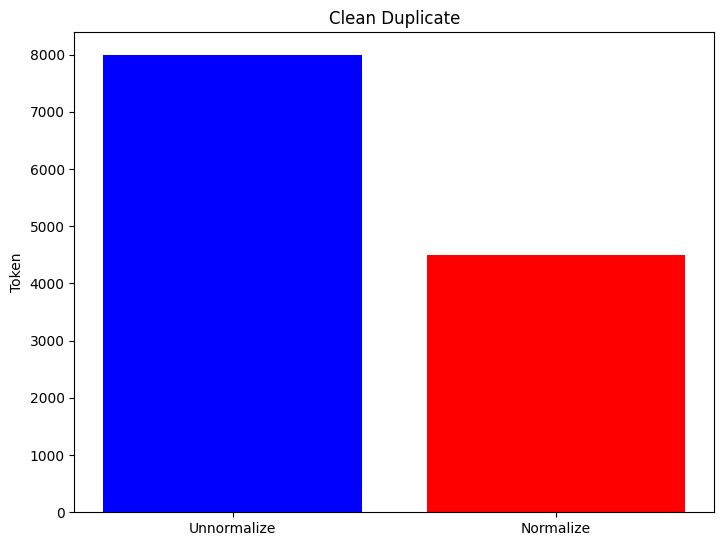

Dataset dinormalisasi sebesar 56.177243710101386%


In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Unnormalize', 'Normalize']
students = [len(unnormalize_clean),len(normalize_clean)]
ax.bar(langs,students,color=['blue','red'])
ax.set_ylabel('Token')
plt.title("Clean Duplicate")
plt.show()
normalpercent = (len(normalize_clean)/len(unnormalize_clean))*100
print("Dataset dinormalisasi sebesar " + str(normalpercent)+"%")

#jika ingin menampilkan grafik sebelum di normalisasi tanpa menghilangkan kata yang duplikat buka komentar ini
#fig = plt.figure()
#ax = fig.add_axes([0,0,1,1])
#langs = ['Unnormalize', 'Normalize']
#students = [len(unnormalize),len(normalize)]
#ax.bar(langs,students,color=['yellow','green'])
#ax.set_ylabel('Token')
#plt.title("With Duplicate")
#plt.show()
#normalpercent = (len(normalize)/len(unnormalize))*100
#print(str(normalpercent)+"%")

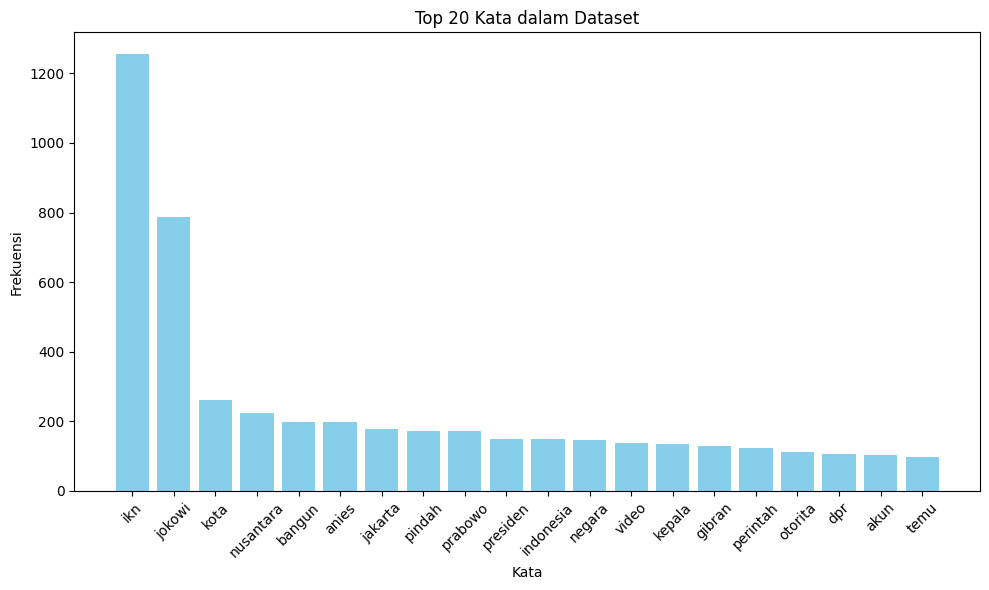

In [ ]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# Hitung frekuensi kata-kata
word_freq = Counter(normalize)

# Ambil 20 kata dengan frekuensi tertinggi
common_words = word_freq.most_common(20)
words, freqs = zip(*common_words)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(words, freqs, color='skyblue')
plt.title('Top 20 Kata dalam Dataset')
plt.xlabel('Kata')
plt.ylabel('Frekuensi')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

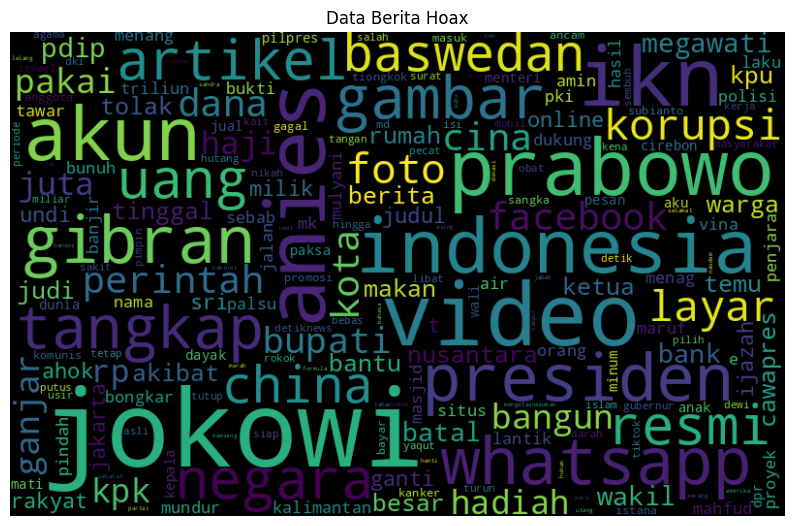

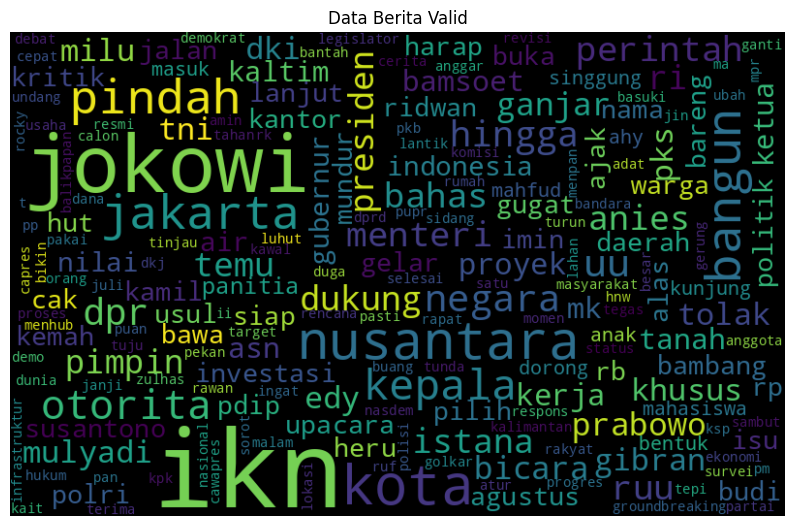

In [ ]:
from wordcloud import WordCloud
all_words = ' '.join(normalize)
wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)
#jika ingin melihat wordcloud all (fake & real) buka komentar ini
#plt.figure(figsize=(10,7))
#plt.imshow(wordcloud, interpolation='bilinear')
#plt.axis("off")
#plt.title("Normalize Data")
#plt.show()

all_words = ' '.join(fake)
wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Data Berita Hoax")
plt.show()

all_words = ' '.join(truth)
wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Data Berita Valid")
plt.show()

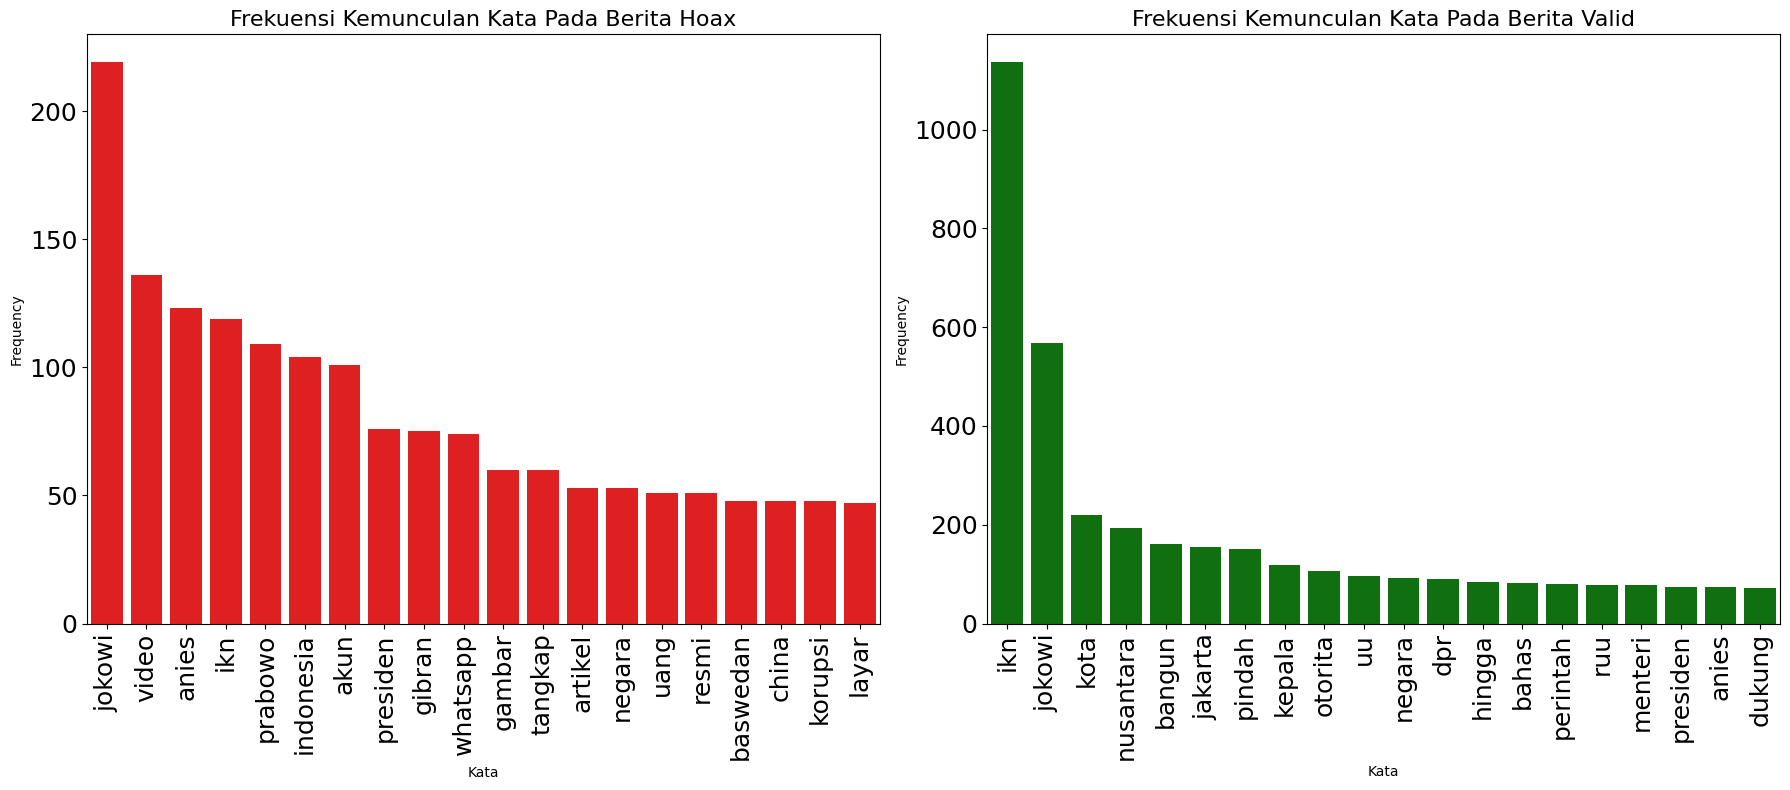

In [ ]:
# Plot frekuensi kata pada berita hoax
token_fake_phrase = fake
frequency_fake = nltk.FreqDist(token_fake_phrase)
df_frequency_fake = pd.DataFrame({"Kata": list(frequency_fake.keys()), "Frequency": list(frequency_fake.values())})
df_frequency_fake = df_frequency_fake.nlargest(columns = "Frequency", n = 20)

# Plot frekuensi kata pada berita valid
token_truth_phrase = truth
frequency_truth = nltk.FreqDist(token_truth_phrase)
df_frequency_truth = pd.DataFrame({"Kata": list(frequency_truth.keys()), "Frequency": list(frequency_truth.values())})
df_frequency_truth = df_frequency_truth.nlargest(columns = "Frequency", n = 20)

# Plot vertikal dengan dua subplots
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# Plot untuk berita hoax
sns.barplot(data = df_frequency_fake, x = "Kata", y = "Frequency", ax = axs[0], color='red')
axs[0].set_title('Frekuensi Kemunculan Kata Pada Berita Hoax', fontsize=16)
axs[0].tick_params(axis='x', rotation=90, labelsize=18)
axs[0].tick_params(axis='y', labelsize=18)

# Plot untuk berita valid
sns.barplot(data = df_frequency_truth, x = "Kata", y = "Frequency", ax = axs[1], color='green')
axs[1].set_title('Frekuensi Kemunculan Kata Pada Berita Valid', fontsize=16)
axs[1].tick_params(axis='x', rotation=90, labelsize=18)
axs[1].tick_params(axis='y', labelsize=18)

plt.tight_layout()
plt.show()

In [ ]:
data['text_preprocessing'] = data['judul_berita'].apply(lambda x: casefolding(x))
# data['deskripsi'] = data['deskripsi'].apply(lambda x: casefolding(x))
data

,judul_berita,label,text_preprocessing
0,Baleg DPR Sebut Presiden Ingin Pembahasan RUU ...,0,baleg dpr sebut presiden ingin pembahasan ruu ...
1,Asa Rakyat Bumi Etam di Balik Pemindahan IKN,0,asa rakyat bumi etam di balik pemindahan ikn
2,Prabowo Bahas Pertahanan IKN Nusantara di Rapi...,0,prabowo bahas pertahanan ikn nusantara di rapi...
3,Kepala BIN: Berpindahnya IKN Akan Jadi Sejarah...,0,kepala bin: berpindahnya ikn akan jadi sejarah...
4,Stafsus Mensesneg: Ide IKN Baru Pikiran Jokowi...,0,stafsus mensesneg: ide ikn baru pikiran jokowi...
...,...,...,...
3522,JOKOWI OBRAL IKN 190 TAHUN UNTUK ASING,1,jokowi obral ikn 190 tahun untuk asing
3523,Jokowi Bangun IKN untuk Rakyat Tiongkok,1,jokowi bangun ikn untuk rakyat tiongkok
3524,"Dulu Dana Haji Dipakai Infrastruktur, Sekarang...",1,"dulu dana haji dipakai infrastruktur, sekarang..."
3525,KPK Bongkar Dana Tapera Digelapkan untuk IKN,1,kpk bongkar dana tapera digelapkan untuk ikn


In [ ]:
data['text_preprocessing'] = data['text_preprocessing'].apply(lambda x: removeDoubleSpaces(replaceThreeOrMore(filtering(x))))
# data['deskripsi'] = data['deskripsi'].apply(lambda x: removeDoubleSpaces(replaceThreeOrMore(filtering(x))))
data

,judul_berita,label,text_preprocessing
0,Baleg DPR Sebut Presiden Ingin Pembahasan RUU ...,0,baleg dpr sebut presiden ingin pembahasan ruu ...
1,Asa Rakyat Bumi Etam di Balik Pemindahan IKN,0,asa rakyat bumi etam di balik pemindahan ikn
2,Prabowo Bahas Pertahanan IKN Nusantara di Rapi...,0,prabowo bahas pertahanan ikn nusantara di rapi...
3,Kepala BIN: Berpindahnya IKN Akan Jadi Sejarah...,0,kepala bin berpindahnya ikn akan jadi sejarah ...
4,Stafsus Mensesneg: Ide IKN Baru Pikiran Jokowi...,0,stafsus mensesneg ide ikn baru pikiran jokowi ...
...,...,...,...
3522,JOKOWI OBRAL IKN 190 TAHUN UNTUK ASING,1,jokowi obral ikn tahun untuk asing
3523,Jokowi Bangun IKN untuk Rakyat Tiongkok,1,jokowi bangun ikn untuk rakyat tiongkok
3524,"Dulu Dana Haji Dipakai Infrastruktur, Sekarang...",1,dulu dana haji dipakai infrastruktur sekarang ...
3525,KPK Bongkar Dana Tapera Digelapkan untuk IKN,1,kpk bongkar dana tapera digelapkan untuk ikn


In [ ]:
text_preprocessing_conversions = data['text_preprocessing'].apply(lambda x: pd.Series(getConversions(x)))
# deskripsi_conversions = data['deskripsi'].apply(lambda x: pd.Series(getConversions(x)))

In [ ]:
text_preprocessing_conversions

,0,1
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
3522,NaN,NaN
3523,NaN,NaN
3524,NaN,NaN
3525,NaN,NaN


In [ ]:
data['text_preprocessing'] = data['text_preprocessing'].apply(lambda x: convertToSlangword(x))
# data['deskripsi'] = data['deskripsi'].apply(lambda x: convertToSlangword(x))
data

,judul_berita,label,text_preprocessing
0,Baleg DPR Sebut Presiden Ingin Pembahasan RUU ...,0,baleg dpr sebut presiden ingin pembahasan ruu ...
1,Asa Rakyat Bumi Etam di Balik Pemindahan IKN,0,asa rakyat bumi etam di balik pemindahan ikn
2,Prabowo Bahas Pertahanan IKN Nusantara di Rapi...,0,prabowo bahas pertahanan ikn nusantara di rapi...
3,Kepala BIN: Berpindahnya IKN Akan Jadi Sejarah...,0,kepala bin berpindahnya ikn akan jadi sejarah ...
4,Stafsus Mensesneg: Ide IKN Baru Pikiran Jokowi...,0,stafsus mensesneg ide ikn baru pikiran jokowi ...
...,...,...,...
3522,JOKOWI OBRAL IKN 190 TAHUN UNTUK ASING,1,jokowi obral ikn tahun untuk asing
3523,Jokowi Bangun IKN untuk Rakyat Tiongkok,1,jokowi bangun ikn untuk rakyat tiongkok
3524,"Dulu Dana Haji Dipakai Infrastruktur, Sekarang...",1,dulu dana haji dipakai infrastruktur sekarang ...
3525,KPK Bongkar Dana Tapera Digelapkan untuk IKN,1,kpk bongkar dana tapera digelapkan untuk ikn


In [ ]:
# data['cleaned_text'] = data['text'].apply(preprocess_text)

# Menampilkan beberapa baris pertama dataset yang telah dipreprocessing
print(data[['judul_berita', 'text_preprocessing']].head())

                                        judul_berita  \
0  Baleg DPR Sebut Presiden Ingin Pembahasan RUU ...   
1       Asa Rakyat Bumi Etam di Balik Pemindahan IKN   
2  Prabowo Bahas Pertahanan IKN Nusantara di Rapi...   
3  Kepala BIN: Berpindahnya IKN Akan Jadi Sejarah...   
4  Stafsus Mensesneg: Ide IKN Baru Pikiran Jokowi...   

                                  text_preprocessing  
0  baleg dpr sebut presiden ingin pembahasan ruu ...  
1       asa rakyat bumi etam di balik pemindahan ikn  
2  prabowo bahas pertahanan ikn nusantara di rapi...  
3  kepala bin berpindahnya ikn akan jadi sejarah ...  
4  stafsus mensesneg ide ikn baru pikiran jokowi ...  


In [ ]:
data

,judul_berita,label,text_preprocessing
0,Baleg DPR Sebut Presiden Ingin Pembahasan RUU ...,0,baleg dpr sebut presiden ingin pembahasan ruu ...
1,Asa Rakyat Bumi Etam di Balik Pemindahan IKN,0,asa rakyat bumi etam di balik pemindahan ikn
2,Prabowo Bahas Pertahanan IKN Nusantara di Rapi...,0,prabowo bahas pertahanan ikn nusantara di rapi...
3,Kepala BIN: Berpindahnya IKN Akan Jadi Sejarah...,0,kepala bin berpindahnya ikn akan jadi sejarah ...
4,Stafsus Mensesneg: Ide IKN Baru Pikiran Jokowi...,0,stafsus mensesneg ide ikn baru pikiran jokowi ...
...,...,...,...
3522,JOKOWI OBRAL IKN 190 TAHUN UNTUK ASING,1,jokowi obral ikn tahun untuk asing
3523,Jokowi Bangun IKN untuk Rakyat Tiongkok,1,jokowi bangun ikn untuk rakyat tiongkok
3524,"Dulu Dana Haji Dipakai Infrastruktur, Sekarang...",1,dulu dana haji dipakai infrastruktur sekarang ...
3525,KPK Bongkar Dana Tapera Digelapkan untuk IKN,1,kpk bongkar dana tapera digelapkan untuk ikn


In [ ]:
# Inisialisasi tokenizer, stopword remover, dan lemmatizer
tokenizerId = Tokenizer()
stopwordId = StopWord()
lemmatizer = Lemmatizer()

# Fungsi untuk tokenisasi
def tokenizeText(text):
    tokens = tokenizerId.tokenize(text)
    return tokens

def removeStopWords(tokens):
    stop_words = set(stopwordId.get_stopword())
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return filtered_tokens

# Fungsi untuk lemmatisasi
def lemmatizeText(token):
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in token]
    return ' '.join(lemmatized_tokens)

In [ ]:
data['tokenize_text'] = data['text_preprocessing'].apply(lambda x: tokenizeText(x))

In [ ]:
data

,judul_berita,label,text_preprocessing,tokenize_text
0,Baleg DPR Sebut Presiden Ingin Pembahasan RUU ...,0,baleg dpr sebut presiden ingin pembahasan ruu ...,"[baleg, dpr, sebut, presiden, ingin, pembahasa..."
1,Asa Rakyat Bumi Etam di Balik Pemindahan IKN,0,asa rakyat bumi etam di balik pemindahan ikn,"[asa, rakyat, bumi, etam, di, balik, pemindaha..."
2,Prabowo Bahas Pertahanan IKN Nusantara di Rapi...,0,prabowo bahas pertahanan ikn nusantara di rapi...,"[prabowo, bahas, pertahanan, ikn, nusantara, d..."
3,Kepala BIN: Berpindahnya IKN Akan Jadi Sejarah...,0,kepala bin berpindahnya ikn akan jadi sejarah ...,"[kepala, bin, berpindah, nya, ikn, akan, jadi,..."
4,Stafsus Mensesneg: Ide IKN Baru Pikiran Jokowi...,0,stafsus mensesneg ide ikn baru pikiran jokowi ...,"[stafsus, mensesneg, ide, ikn, baru, pikiran, ..."
...,...,...,...,...
3522,JOKOWI OBRAL IKN 190 TAHUN UNTUK ASING,1,jokowi obral ikn tahun untuk asing,"[jokowi, obral, ikn, tahun, untuk, asing]"
3523,Jokowi Bangun IKN untuk Rakyat Tiongkok,1,jokowi bangun ikn untuk rakyat tiongkok,"[jokowi, bangun, ikn, untuk, rakyat, tiongkok]"
3524,"Dulu Dana Haji Dipakai Infrastruktur, Sekarang...",1,dulu dana haji dipakai infrastruktur sekarang ...,"[dulu, dana, haji, dipakai, infrastruktur, sek..."
3525,KPK Bongkar Dana Tapera Digelapkan untuk IKN,1,kpk bongkar dana tapera digelapkan untuk ikn,"[kpk, bongkar, dana, tapera, digelapkan, untuk..."


In [ ]:
data['stopword_remove_text'] = data['tokenize_text'].apply(removeStopWords)
data = data.drop(columns=["tokenize_text"])
data

,judul_berita,label,text_preprocessing,stopword_remove_text
0,Baleg DPR Sebut Presiden Ingin Pembahasan RUU ...,0,baleg dpr sebut presiden ingin pembahasan ruu ...,"[baleg, dpr, presiden, pembahasan, ruu, ikn, j..."
1,Asa Rakyat Bumi Etam di Balik Pemindahan IKN,0,asa rakyat bumi etam di balik pemindahan ikn,"[asa, rakyat, bumi, etam, pemindahan, ikn]"
2,Prabowo Bahas Pertahanan IKN Nusantara di Rapi...,0,prabowo bahas pertahanan ikn nusantara di rapi...,"[prabowo, bahas, pertahanan, ikn, nusantara, r..."
3,Kepala BIN: Berpindahnya IKN Akan Jadi Sejarah...,0,kepala bin berpindahnya ikn akan jadi sejarah ...,"[kepala, bin, berpindah, ikn, sejarah, indonesia]"
4,Stafsus Mensesneg: Ide IKN Baru Pikiran Jokowi...,0,stafsus mensesneg ide ikn baru pikiran jokowi ...,"[stafsus, mensesneg, ide, ikn, pikiran, jokowi]"
...,...,...,...,...
3522,JOKOWI OBRAL IKN 190 TAHUN UNTUK ASING,1,jokowi obral ikn tahun untuk asing,"[jokowi, obral, ikn, asing]"
3523,Jokowi Bangun IKN untuk Rakyat Tiongkok,1,jokowi bangun ikn untuk rakyat tiongkok,"[jokowi, bangun, ikn, rakyat, tiongkok]"
3524,"Dulu Dana Haji Dipakai Infrastruktur, Sekarang...",1,dulu dana haji dipakai infrastruktur sekarang ...,"[dana, haji, dipakai, infrastruktur, menteri, ..."
3525,KPK Bongkar Dana Tapera Digelapkan untuk IKN,1,kpk bongkar dana tapera digelapkan untuk ikn,"[kpk, bongkar, dana, tapera, digelapkan, ikn]"


In [ ]:
data['lemmatized_text'] = data['stopword_remove_text'].apply(lemmatizeText)
data = data.drop(columns=["stopword_remove_text"])
data

,judul_berita,label,text_preprocessing,lemmatized_text
0,Baleg DPR Sebut Presiden Ingin Pembahasan RUU ...,0,baleg dpr sebut presiden ingin pembahasan ruu ...,baleg dpr presiden bahas ruu ikn jalan
1,Asa Rakyat Bumi Etam di Balik Pemindahan IKN,0,asa rakyat bumi etam di balik pemindahan ikn,asa rakyat bumi etam pindah ikn
2,Prabowo Bahas Pertahanan IKN Nusantara di Rapi...,0,prabowo bahas pertahanan ikn nusantara di rapi...,prabowo bahas tahan ikn nusantara rapim kemenhan
3,Kepala BIN: Berpindahnya IKN Akan Jadi Sejarah...,0,kepala bin berpindahnya ikn akan jadi sejarah ...,kepala bin pindah ikn sejarah indonesia
4,Stafsus Mensesneg: Ide IKN Baru Pikiran Jokowi...,0,stafsus mensesneg ide ikn baru pikiran jokowi ...,stafsus mensesneg ide ikn pikir jokowi
...,...,...,...,...
3522,JOKOWI OBRAL IKN 190 TAHUN UNTUK ASING,1,jokowi obral ikn tahun untuk asing,jokowi obral ikn asing
3523,Jokowi Bangun IKN untuk Rakyat Tiongkok,1,jokowi bangun ikn untuk rakyat tiongkok,jokowi bangun ikn rakyat tiongkok
3524,"Dulu Dana Haji Dipakai Infrastruktur, Sekarang...",1,dulu dana haji dipakai infrastruktur sekarang ...,dana haji pakai infrastruktur menteri agama da...
3525,KPK Bongkar Dana Tapera Digelapkan untuk IKN,1,kpk bongkar dana tapera digelapkan untuk ikn,kpk bongkar dana tapera gelap ikn


In [ ]:
data['text_preprocessing'] = data['text_preprocessing'].apply(preprocess_text)

In [ ]:
# Inisialisasi tokenizer, stopword remover, dan lemmatizer
tokenizerId = Tokenizer()
stopwordId = StopWord()
lemmatizer = Lemmatizer()

def text_process2(text):
    # Tokenisasi
    tokens = tokenizerId.tokenize(text)

    # Penghapusan stopword
    stop_words = set(stopwordId.get_stopword())
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

    # Lemmatization
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    return ' '.join(lemmatized_tokens)


In [ ]:
# Terapkan preprocessing pada kolom 'cleaned_text'
data['cleaned_text'] = data['text_preprocessing'].apply(text_process2)

# Tampilkan beberapa baris pertama hasil preprocessing
print(data[['text_preprocessing', 'cleaned_text']].head())

                                  text_preprocessing  \
0  baleg dpr sebut presiden ingin pembahasan ruu ...   
1       asa rakyat bumi etam di balik pemindahan ikn   
2  prabowo bahas pertahanan ikn nusantara di rapi...   
3  kepala bin berpindahnya ikn akan jadi sejarah ...   
4  stafsus mensesneg ide ikn baru pikiran jokowi ...   

                                       cleaned_text  
0            baleg dpr presiden bahas ruu ikn jalan  
1                   asa rakyat bumi etam pindah ikn  
2  prabowo bahas tahan ikn nusantara rapim kemenhan  
3           kepala bin pindah ikn sejarah indonesia  
4            stafsus mensesneg ide ikn pikir jokowi  


In [ ]:
data

,judul_berita,label,text_preprocessing,lemmatized_text,cleaned_text
0,Baleg DPR Sebut Presiden Ingin Pembahasan RUU ...,0,baleg dpr sebut presiden ingin pembahasan ruu ...,baleg dpr presiden bahas ruu ikn jalan,baleg dpr presiden bahas ruu ikn jalan
1,Asa Rakyat Bumi Etam di Balik Pemindahan IKN,0,asa rakyat bumi etam di balik pemindahan ikn,asa rakyat bumi etam pindah ikn,asa rakyat bumi etam pindah ikn
2,Prabowo Bahas Pertahanan IKN Nusantara di Rapi...,0,prabowo bahas pertahanan ikn nusantara di rapi...,prabowo bahas tahan ikn nusantara rapim kemenhan,prabowo bahas tahan ikn nusantara rapim kemenhan
3,Kepala BIN: Berpindahnya IKN Akan Jadi Sejarah...,0,kepala bin berpindahnya ikn akan jadi sejarah ...,kepala bin pindah ikn sejarah indonesia,kepala bin pindah ikn sejarah indonesia
4,Stafsus Mensesneg: Ide IKN Baru Pikiran Jokowi...,0,stafsus mensesneg ide ikn baru pikiran jokowi ...,stafsus mensesneg ide ikn pikir jokowi,stafsus mensesneg ide ikn pikir jokowi
...,...,...,...,...,...
3522,JOKOWI OBRAL IKN 190 TAHUN UNTUK ASING,1,jokowi obral ikn tahun untuk asing,jokowi obral ikn asing,jokowi obral ikn asing
3523,Jokowi Bangun IKN untuk Rakyat Tiongkok,1,jokowi bangun ikn untuk rakyat tiongkok,jokowi bangun ikn rakyat tiongkok,jokowi bangun ikn rakyat tiongkok
3524,"Dulu Dana Haji Dipakai Infrastruktur, Sekarang...",1,dulu dana haji dipakai infrastruktur sekarang ...,dana haji pakai infrastruktur menteri agama da...,dana haji pakai infrastruktur menteri agama da...
3525,KPK Bongkar Dana Tapera Digelapkan untuk IKN,1,kpk bongkar dana tapera digelapkan untuk ikn,kpk bongkar dana tapera gelap ikn,kpk bongkar dana tapera gelap ikn


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Feature Extraction
vectorizer_data = TfidfVectorizer(max_features=1000)
response = vectorizer_data.fit_transform(data['lemmatized_text'])
print(response)

  (0, 362)	0.4128736568606878
  (0, 338)	0.1620927327180205
  (0, 777)	0.38017106755796753
  (0, 75)	0.3753558746505195
  (0, 712)	0.3302429712215301
  (0, 225)	0.3563348528029303
  (0, 84)	0.5308523983786414
  (1, 686)	0.4078151609629314
  (1, 161)	0.7070360526729693
  (1, 746)	0.5393940679959638
  (1, 338)	0.20698032302653777
  (2, 613)	0.39610337580628663
  (2, 865)	0.6073521817245479
  (2, 709)	0.4246816533474636
  (2, 338)	0.2149155178401742
  (2, 75)	0.4976768595492963
  (3, 340)	0.3431298442370862
  (3, 799)	0.5569501799451586
  (3, 137)	0.5569501799451586
  (3, 439)	0.35254126257821766
  (3, 686)	0.33076760019566326
  (3, 338)	0.16787601660899018
  (4, 380)	0.20019036115001423
  (4, 682)	0.5667390535337977
  (4, 560)	0.5279247640443355
  :	:
  (3522, 338)	0.2965136013900808
  (3523, 915)	0.6570271732747377
  (3523, 93)	0.3996436592664399
  (3523, 380)	0.25723471077099086
  (3523, 746)	0.5463334914196576
  (3523, 338)	0.20964317044566216
  (3524, 7)	0.3109281417395026
  (3524, 3

In [ ]:
vectorizer_data.get_feature_names_out()

array(['abipraya', 'acara', 'aceh', 'ada', 'adat', 'adil', 'adu', 'agama',
       'agenda', 'agustus', 'ahli', 'ahmad', 'ahok', 'ahy', 'air',
       'airlangga', 'ajak', 'ajar', 'ajuk', 'akibat', 'aksi', 'aku',
       'akuarium', 'akun', 'al', 'alam', 'alas', 'alat', 'alih',
       'alutsista', 'aman', 'ambil', 'amerika', 'amien', 'amin', 'an',
       'anak', 'ancam', 'andi', 'aneh', 'anggap', 'anggar', 'anggota',
       'angkat', 'anies', 'antusias', 'anwar', 'aparat', 'apbn',
       'aplikasi', 'apresiasi', 'april', 'arab', 'arah', 'arif',
       'arsitek', 'arteria', 'artikel', 'as', 'asean', 'aset', 'asing',
       'asli', 'asn', 'atas', 'atr', 'atur', 'au', 'australia', 'awas',
       'ayah', 'babi', 'baca', 'badan', 'bagi', 'bahas', 'bahasa',
       'bahaya', 'bahlil', 'baik', 'baju', 'bakar', 'bal', 'balas',
       'baleg', 'baliho', 'balik', 'balikpapan', 'bambang', 'bamsoet',
       'bandara', 'bandung', 'bangsa', 'bangun', 'banjir', 'bank',
       'bansos', 'bantah', 'bantu',

In [ ]:
response.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
dfTfIdf = pd.DataFrame(
    response.todense().T,
    index=vectorizer_data.get_feature_names_out(),
    columns=[f'D{i+1}' for i in range(len(data['lemmatized_text']))])
dfTfIdf

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D3518,D3519,D3520,D3521,D3522,D3523,D3524,D3525,D3526,D3527
abipraya,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
acara,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aceh,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ada,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
adat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wujud,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
xi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yahya,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yaqut,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Filter DataFrame untuk dokumen 1-5
df_filtered = dfTfIdf.iloc[:, :5]
df_filtered
# Hapus token yang memiliki nilai 0 pada semua dokumen yang dipilih
df_filtered_nonzero = df_filtered.loc[~(df_filtered == 0).all(axis=1)]
df_filtered_nonzero


,D1,D2,D3,D4,D5
bahas,0.375356,0.000000,0.497677,0.000000,0.000000
baleg,0.530852,0.000000,0.000000,0.000000,0.000000
bin,0.000000,0.000000,0.000000,0.556950,0.000000
bumi,0.000000,0.707036,0.000000,0.000000,0.000000
dpr,0.356335,0.000000,0.000000,0.000000,0.000000
ikn,0.162093,0.206980,0.214916,0.167876,0.163153
indonesia,0.000000,0.000000,0.000000,0.343130,0.000000
jalan,0.412874,0.000000,0.000000,0.000000,0.000000
jokowi,0.000000,0.000000,0.000000,0.000000,0.200190
kepala,0.000000,0.000000,0.000000,0.352541,0.000000


In [ ]:
tfidf_df_dataFrame = pd.DataFrame(response.todense(), columns=vectorizer_data.get_feature_names_out())

In [ ]:
word_sum = tfidf_df_dataFrame.sum(axis=0).sort_values(ascending=False)


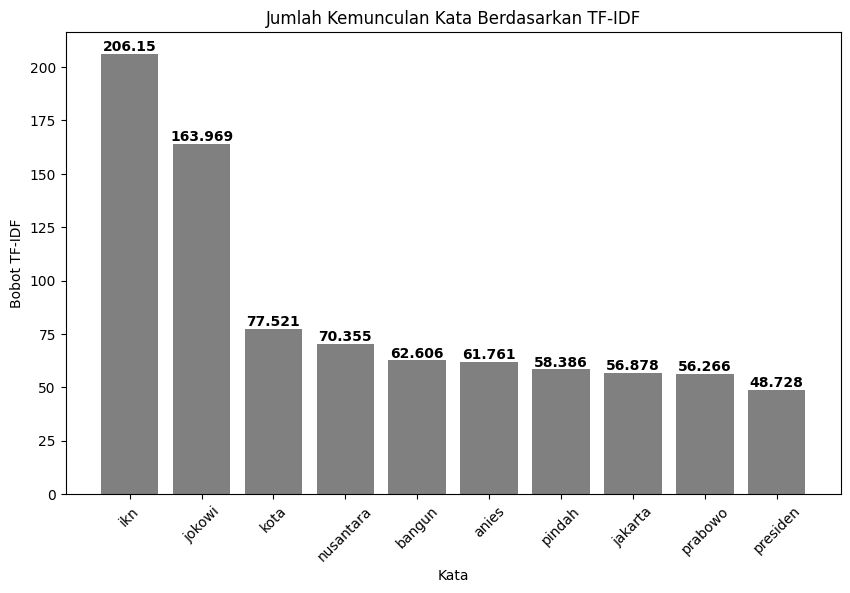

In [ ]:
# Plot the top 10 words with the highest TF-IDF scores
top_n = 10
top_words = word_sum.head(top_n)

plt.figure(figsize=(10, 6))
plt.bar(top_words.index, top_words.values, color='gray')
plt.xlabel('Kata')
plt.ylabel('Bobot TF-IDF')
plt.title('Jumlah Kemunculan Kata Berdasarkan TF-IDF')
plt.xticks(rotation=45)
for i, v in enumerate(top_words.values):
    plt.text(i, v + 0.01, str(round(v, 3)), ha='center', va='bottom', fontweight='bold')
plt.show()


In [ ]:
data

,judul_berita,label,text_preprocessing,lemmatized_text,cleaned_text
0,Baleg DPR Sebut Presiden Ingin Pembahasan RUU ...,0,baleg dpr sebut presiden ingin pembahasan ruu ...,baleg dpr presiden bahas ruu ikn jalan,baleg dpr presiden bahas ruu ikn jalan
1,Asa Rakyat Bumi Etam di Balik Pemindahan IKN,0,asa rakyat bumi etam di balik pemindahan ikn,asa rakyat bumi etam pindah ikn,asa rakyat bumi etam pindah ikn
2,Prabowo Bahas Pertahanan IKN Nusantara di Rapi...,0,prabowo bahas pertahanan ikn nusantara di rapi...,prabowo bahas tahan ikn nusantara rapim kemenhan,prabowo bahas tahan ikn nusantara rapim kemenhan
3,Kepala BIN: Berpindahnya IKN Akan Jadi Sejarah...,0,kepala bin berpindahnya ikn akan jadi sejarah ...,kepala bin pindah ikn sejarah indonesia,kepala bin pindah ikn sejarah indonesia
4,Stafsus Mensesneg: Ide IKN Baru Pikiran Jokowi...,0,stafsus mensesneg ide ikn baru pikiran jokowi ...,stafsus mensesneg ide ikn pikir jokowi,stafsus mensesneg ide ikn pikir jokowi
...,...,...,...,...,...
3522,JOKOWI OBRAL IKN 190 TAHUN UNTUK ASING,1,jokowi obral ikn tahun untuk asing,jokowi obral ikn asing,jokowi obral ikn asing
3523,Jokowi Bangun IKN untuk Rakyat Tiongkok,1,jokowi bangun ikn untuk rakyat tiongkok,jokowi bangun ikn rakyat tiongkok,jokowi bangun ikn rakyat tiongkok
3524,"Dulu Dana Haji Dipakai Infrastruktur, Sekarang...",1,dulu dana haji dipakai infrastruktur sekarang ...,dana haji pakai infrastruktur menteri agama da...,dana haji pakai infrastruktur menteri agama da...
3525,KPK Bongkar Dana Tapera Digelapkan untuk IKN,1,kpk bongkar dana tapera digelapkan untuk ikn,kpk bongkar dana tapera gelap ikn,kpk bongkar dana tapera gelap ikn


In [ ]:
from sklearn.model_selection import train_test_split

# Misalkan 'label' adalah kolom yang berisi label hoax atau tidak
# X = data['lemmatized_text']
X = data['cleaned_text']
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Jumlah data keseluruhan
print('Jumlah data Predictor (X) :', X.shape)
print('Jumlah data Target (y) :', y.shape)
print('==========================================')
# Jumlah Data Train
print('Jumlah data Train (X) :', X_train.shape)
print('Jumlah data Train (y) :', y_train.shape)
print('===========================================')
# Jumlah Data Test
print('Jumlah data Test (X) :', X_test.shape)
print('Jumlah data Test (y) :', y_test.shape)
print('===========================================')

Jumlah data Predictor (X) : (3527,)
Jumlah data Target (y) : (3527,)
Jumlah data Train (X) : (2821,)
Jumlah data Train (y) : (2821,)
Jumlah data Test (X) : (706,)
Jumlah data Test (y) : (706,)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [ ]:
# Menampilkan fitur yang dihasilkan oleh TfidfVectorizer
feature_names = vectorizer.get_feature_names_out()
print("Fitur yang dihasilkan oleh TfidfVectorizer:", feature_names)


Fitur yang dihasilkan oleh TfidfVectorizer: ['abadi' 'abai' 'abc' ... 'zon' 'zulfan' 'zulhas']


In [ ]:
# Mengonversi matriks ke array dan menampilkan sebagian dari matriks TF-IDF
X_train_tfidf_array = X_train_tfidf.toarray()
X_test_tfidf_array = X_test_tfidf.toarray()
print("Matriks TF-IDF untuk data latih:")
print(X_train_tfidf_array[:5])
print("Matriks TF-IDF untuk data uji:")
print(X_test_tfidf_array[:5])

# Fungsi untuk menampilkan nilai TF-IDF dari dokumen tertentu
def display_tfidf_values(doc_index, tfidf_matrix, feature_names):
    tfidf_scores = tfidf_matrix[doc_index]
    sorted_indices = np.argsort(tfidf_scores.toarray()).flatten()[::-1]
    top_n = 10  # Menampilkan 10 kata teratas berdasarkan skor TF-IDF

    for i in sorted_indices[:top_n]:
        print(f"Word: {feature_names[i]}, TF-IDF: {tfidf_scores[0, i]}")

# Menampilkan nilai TF-IDF untuk dokumen pertama dalam data latih
print("Nilai TF-IDF untuk dokumen pertama dalam data latih:")
display_tfidf_values(0, X_train_tfidf, feature_names)

# Menampilkan nilai TF-IDF untuk dokumen pertama dalam data uji
print("Nilai TF-IDF untuk dokumen pertama dalam data uji:")
display_tfidf_values(0, X_test_tfidf, feature_names)

Matriks TF-IDF untuk data latih:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Matriks TF-IDF untuk data uji:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Nilai TF-IDF untuk dokumen pertama dalam data latih:
Word: kuntilanak, TF-IDF: 0.5273325457276601
Word: tindak, TF-IDF: 0.49300234416265937
Word: kapolri, TF-IDF: 0.4341661839958305
Word: legislator, TF-IDF: 0.4069167700249591
Word: kaltim, TF-IDF: 0.35325280156491506
Word: ikhlas, TF-IDF: 0.0
Word: ijazah, TF-IDF: 0.0
Word: ik, TF-IDF: 0.0
Word: ikan, TF-IDF: 0.0
Word: iket, TF-IDF: 0.0
Nilai TF-IDF untuk dokumen pertama dalam data uji:
Word: jateng, TF-IDF: 0.5617306847042532
Word: ungkap, TF-IDF: 0.48694636594692337
Word: bawa, TF-IDF: 0.3898002430199903
Word: air, TF-IDF: 0.33994677371510607
Word: ganjar, TF-IDF: 0.3081166957397384
Word: nusantara, TF-IDF: 0.2554213486406

Model SVM dengan TF-IDF Tanpa SMOTE

Akurasi Training: 0.9961006735200284
Akurasi Testing: 0.943342776203966

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       441
           1       0.93      0.92      0.92       265

    accuracy                           0.94       706
   macro avg       0.94      0.94      0.94       706
weighted avg       0.94      0.94      0.94       706


Confusion Matrix: [[423  18]
 [ 22 243]]

Accuracy: 0.943342776203966
Model Prediction Accuracy: 94.33%

Precision: 0.9310344827586207
Recall: 0.9169811320754717
F1-Score: 0.9239543726235742



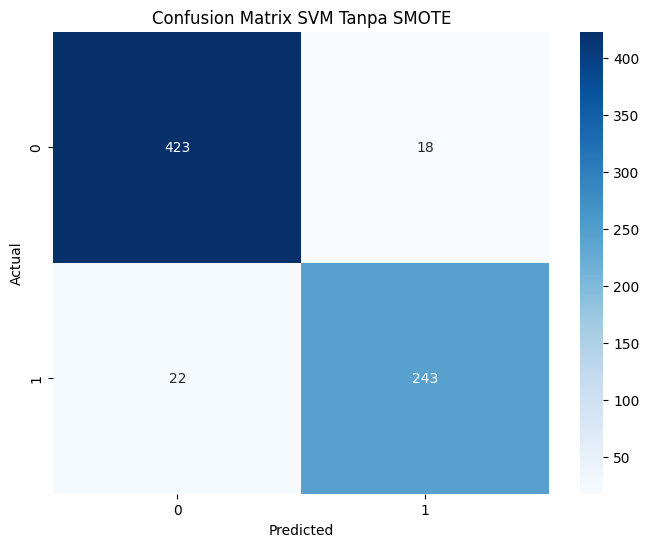

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Melatih model SVM
svm_model = SVC()
svm_model.fit(X_train_tfidf, y_train)

# Memprediksi data uji
y_pred_svm = svm_model.predict(X_test_tfidf)

# Evaluasi model SVM
# print("SVM Classification Report:")
# print(classification_report(y_test, y_pred_svm))
# print("SVM Accuracy Score:", accuracy_score(y_test, y_pred_svm))


# Evaluation
print("Model SVM dengan TF-IDF Tanpa SMOTE")
print()
print(f"Akurasi Training: {svm_model.score(X_train_tfidf, y_train)}")
print(f"Akurasi Testing: {svm_model.score(X_test_tfidf, y_test)}")
print()
print(classification_report(y_test, y_pred_svm))
print()
print('Confusion Matrix:', confusion_matrix(y_test, y_pred_svm))
print()
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm)}")
print('Model Prediction Accuracy:', str(np.round(accuracy_score(y_test, y_pred_svm) * 100, 2)) + '%')
print()
print(f"Precision: {precision_score(y_test, y_pred_svm)}")
print(f"Recall: {recall_score(y_test, y_pred_svm)}")
print(f"F1-Score: {f1_score(y_test, y_pred_svm)}")

def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

print()
plot_confusion_matrix(y_test, y_pred_svm, [0, 1], 'Confusion Matrix SVM Tanpa SMOTE')


Model GB dengan TF-IDF Tanpa SMOTE

Akurasi Training: 0.8940092165898618
Akurasi Testing: 0.8654390934844193

              precision    recall  f1-score   support

           0       0.93      0.85      0.89       441
           1       0.78      0.89      0.83       265

    accuracy                           0.87       706
   macro avg       0.85      0.87      0.86       706
weighted avg       0.87      0.87      0.87       706


Confusion Matrix: [[375  66]
 [ 29 236]]

Accuracy: 0.8654390934844193
Model Prediction Accuracy: 86.54%

Precision: 0.7814569536423841
Recall: 0.8905660377358491
F1-Score: 0.8324514991181657



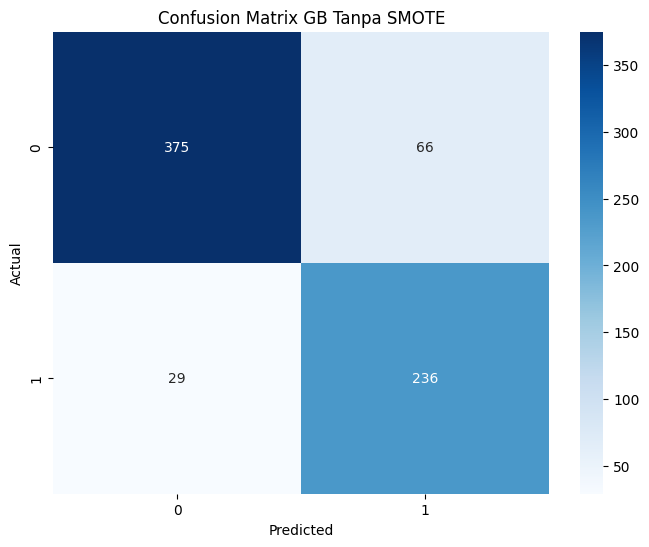

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Melatih model Gradient Boosting
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train_tfidf, y_train)

# Memprediksi data uji
y_pred_gb = gb_model.predict(X_test_tfidf)

# Evaluasi model Gradient Boosting
# print("Gradient Boosting Classification Report:")
# print(classification_report(y_test, y_pred_gb))
# print("Gradient Boosting Accuracy Score:", accuracy_score(y_test, y_pred_gb))


# Evaluation
print("Model GB dengan TF-IDF Tanpa SMOTE")
print()
print(f"Akurasi Training: {gb_model.score(X_train_tfidf, y_train)}")
print(f"Akurasi Testing: {gb_model.score(X_test_tfidf, y_test)}")
print()
print(classification_report(y_test, y_pred_gb))
print()
print('Confusion Matrix:', confusion_matrix(y_test, y_pred_gb))
print()
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb)}")
print('Model Prediction Accuracy:', str(np.round(accuracy_score(y_test, y_pred_gb) * 100, 2)) + '%')
print()
print(f"Precision: {precision_score(y_test, y_pred_gb)}")
print(f"Recall: {recall_score(y_test, y_pred_gb)}")
print(f"F1-Score: {f1_score(y_test, y_pred_gb)}")

def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

print()
plot_confusion_matrix(y_test, y_pred_gb, [0, 1], 'Confusion Matrix GB Tanpa SMOTE')


In [ ]:
from sklearn.model_selection import cross_val_score

# Cross-validation untuk SVM
svm_scores = cross_val_score(svm_model, X_train_tfidf, y_train, cv=5)
print("SVM Cross-Validation Train Scores:", svm_scores)
print("SVM Cross-Validation Train Mean Score:", svm_scores.mean())

svm_scores = cross_val_score(svm_model, X_test_tfidf, y_test, cv=5)
print("SVM Cross-Validation Test Scores:", svm_scores)
print("SVM Cross-Validation Test Mean Score:", svm_scores.mean())

# Cross-validation untuk Gradient Boosting
gb_scores = cross_val_score(gb_model, X_train_tfidf, y_train, cv=5)
print("Gradient Boosting Cross-Validation Train Scores:", gb_scores)
print("Gradient Boosting Cross-Validation Train Mean Score:", gb_scores.mean())

gb_scores = cross_val_score(gb_model, X_test_tfidf, y_test, cv=5)
print("Gradient Boosting Cross-Validation Test Scores:", gb_scores)
print("Gradient Boosting Cross-Validation Test Mean Score:", gb_scores.mean())


SVM Cross-Validation Train Scores: [0.94159292 0.92907801 0.93617021 0.92907801 0.93971631]
SVM Cross-Validation Train Mean Score: 0.9351270947090944
SVM Cross-Validation Test Scores: [0.85211268 0.85815603 0.93617021 0.81560284 0.93617021]
SVM Cross-Validation Test Mean Score: 0.879642393367296
Gradient Boosting Cross-Validation Train Scores: [0.84247788 0.85638298 0.83510638 0.83156028 0.87056738]
Gradient Boosting Cross-Validation Train Mean Score: 0.8472189794765581
Gradient Boosting Cross-Validation Test Scores: [0.81690141 0.86524823 0.88652482 0.78723404 0.83687943]
Gradient Boosting Cross-Validation Test Mean Score: 0.8385575866546798


In [ ]:
import joblib
print(joblib.__version__)
import pickle

model_path = '/content/drive/MyDrive/ta_deteksi_hoax/model/svm_no_smote_model_hoax_detection.pkl'
joblib.dump(svm_model, model_path)

1.4.2


['/content/drive/MyDrive/ta_deteksi_hoax/model/svm_no_smote_model_hoax_detection.pkl']

In [ ]:
model_path = '/content/drive/MyDrive/ta_deteksi_hoax/model/gb_no_smote_model_hoax_detection.pkl'
joblib.dump(gb_model, model_path)

['/content/drive/MyDrive/ta_deteksi_hoax/model/gb_no_smote_model_hoax_detection.pkl']

Best parameters for SVM: {'C': 20.59449429580245}
Best cross-validation score for SVM: 0.8810153515749283
Model SVM dengan TF-IDF Tuning Tanpa SMOTE

Akurasi Training: 0.8810153515749283
Akurasi Testing: 0.8841354723707665

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       403
           1       0.79      0.80      0.80       158

    accuracy                           0.88       561
   macro avg       0.86      0.86      0.86       561
weighted avg       0.88      0.88      0.88       561


Confusion Matrix: [[369  34]
 [ 31 127]]

Accuracy: 0.8841354723707665
Model Prediction Accuracy: 88.41%

Precision: 0.7888198757763976
Recall: 0.8037974683544303
F1-Score: 0.7962382445141065



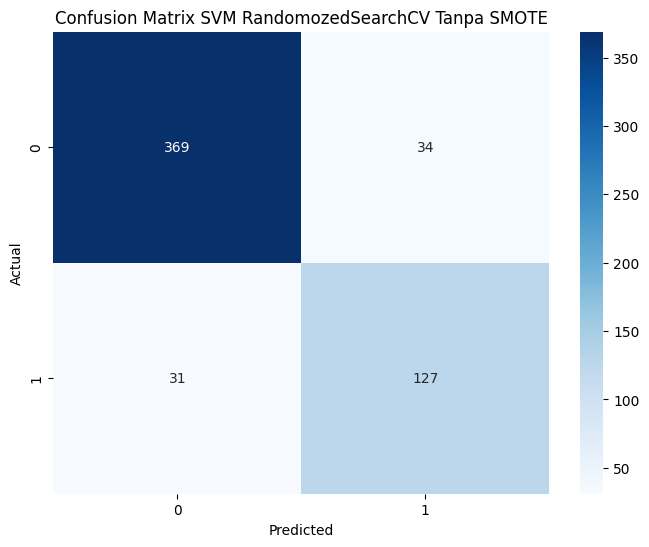

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

svm_model_randomized = SVC(kernel='linear', random_state=42)

# Parameter untuk Randomized Search
param_dist_svm = {'C': uniform(0.01, 1000)}

# Randomized Search untuk SVM
random_search_svm = RandomizedSearchCV(svm_model_randomized, param_distributions=param_dist_svm, n_iter=50, cv=5, random_state=42)
random_search_svm.fit(X_train_tfidf, y_train)

print("Best parameters for SVM:", random_search_svm.best_params_)
print("Best cross-validation score for SVM:", random_search_svm.best_score_)

# Prediksi dan evaluasi SVM
y_pred_randomize_svm = random_search_svm.predict(X_test_tfidf)
# print("SVM Classification Report:")
# print(classification_report(y_test, y_pred_randomize_svm))
# print("SVM Accuracy Score:", accuracy_score(y_test, y_pred_randomize_svm))

# Evaluation
print("Model SVM dengan TF-IDF Tuning Tanpa SMOTE")
print()
print(f"Akurasi Training: {random_search_svm.best_score_}")
print(f"Akurasi Testing: {accuracy_score(y_test, y_pred_randomize_svm)}")
print()
print(classification_report(y_test, y_pred_randomize_svm))
print()
print('Confusion Matrix:', confusion_matrix(y_test, y_pred_randomize_svm))
print()
print(f"Accuracy: {accuracy_score(y_test, y_pred_randomize_svm)}")
print('Model Prediction Accuracy:', str(np.round(accuracy_score(y_test, y_pred_randomize_svm) * 100, 2)) + '%')
print()
print(f"Precision: {precision_score(y_test, y_pred_randomize_svm)}")
print(f"Recall: {recall_score(y_test, y_pred_randomize_svm)}")
print(f"F1-Score: {f1_score(y_test, y_pred_randomize_svm)}")

def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

print()
plot_confusion_matrix(y_test, y_pred_randomize_svm, [0, 1], 'Confusion Matrix SVM RandomozedSearchCV Tanpa SMOTE')



Best parameters for Gradient Boosting: {'learning_rate': 0.33434502100527397, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 178}
Best cross-validation score for Gradient Boosting: 0.8872494432071271
Model GB dengan TF-IDF Tuning Tanpa SMOTE

Akurasi Training: 0.8872494432071271
Akurasi Testing: 0.8770053475935828

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       403
           1       0.87      0.66      0.75       158

    accuracy                           0.88       561
   macro avg       0.88      0.81      0.83       561
weighted avg       0.88      0.88      0.87       561


Confusion Matrix:
[[388  15]
 [ 54 104]]

Accuracy: 0.8770053475935828
Model Prediction Accuracy: 87.7%

Precision: 0.8739495798319328
Recall: 0.6582278481012658
F1-Score: 0.7509025270758122


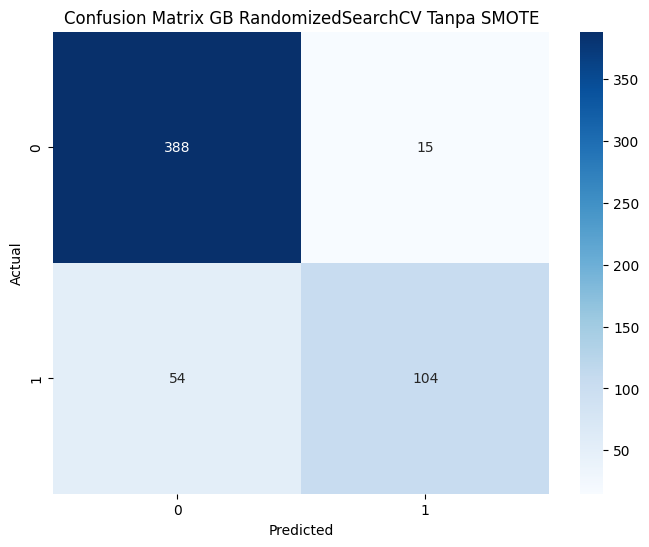

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Inisialisasi model Gradient Boosting
gb_model_randomized = GradientBoostingClassifier(random_state=42)

# Parameter untuk Randomized Search
param_dist_gb = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 1),
    'max_depth': randint(1, 5),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}

# Randomized Search untuk Gradient Boosting
random_search_gb = RandomizedSearchCV(gb_model_randomized, param_distributions=param_dist_gb, n_iter=50, cv=5, random_state=42)
random_search_gb.fit(X_train_tfidf, y_train)

print("Best parameters for Gradient Boosting:", random_search_gb.best_params_)
print("Best cross-validation score for Gradient Boosting:", random_search_gb.best_score_)

# Prediksi dan evaluasi Gradient Boosting
y_pred_random_gb = random_search_gb.predict(X_test_tfidf)

# Evaluation
print("Model GB dengan TF-IDF Tuning Tanpa SMOTE")
print()
print(f"Akurasi Training: {random_search_gb.best_score_}")
print(f"Akurasi Testing: {accuracy_score(y_test, y_pred_random_gb)}")
print()
print(classification_report(y_test, y_pred_random_gb))
print()
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_random_gb))
print()
print(f"Accuracy: {accuracy_score(y_test, y_pred_random_gb)}")
print('Model Prediction Accuracy:', str(np.round(accuracy_score(y_test, y_pred_random_gb) * 100, 2)) + '%')
print()
print(f"Precision: {precision_score(y_test, y_pred_random_gb)}")
print(f"Recall: {recall_score(y_test, y_pred_random_gb)}")
print(f"F1-Score: {f1_score(y_test, y_pred_random_gb)}")

def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test, y_pred_random_gb, [0, 1], 'Confusion Matrix GB RandomizedSearchCV Tanpa SMOTE')


In [ ]:
import joblib
print(joblib.__version__)
import pickle

model_path = '/content/drive/MyDrive/ta_deteksi_hoax/model/svm_no_smote_randomized_model_hoax_detection.pkl'
joblib.dump(random_search_svm, model_path)

1.4.2


['/content/drive/MyDrive/ta_deteksi_hoax/model/svm_no_smote_randomized_model_hoax_detection.pkl']

In [ ]:
model_path = '/content/drive/MyDrive/ta_deteksi_hoax/model/gb_no_smote_randomized_model_hoax_detection.pkl'
joblib.dump(random_search_gb, model_path)

['/content/drive/MyDrive/ta_deteksi_hoax/model/gb_no_smote_randomized_model_hoax_detection.pkl']

In [ ]:
!pip uninstall -y scikit-learn imbalanced-learn
!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1

Found existing installation: scikit-learn 1.5.1
Uninstalling scikit-learn-1.5.1:
  Successfully uninstalled scikit-learn-1.5.1
Found existing installation: imbalanced-learn 0.10.1
Uninstalling imbalanced-learn-0.10.1:
  Successfully uninstalled imbalanced-learn-0.10.1
  Using cached scikit_learn-1.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.6 MB)
  Using cached imbalanced_learn-0.10.1-py3-none-any.whl (226 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nlp-id 0.1.16.0 requires scikit-learn==1.5.1, but you have scikit-learn 1.2.2 which is incompatible.


Jumlah distribusi kelas sebelum SMOTE: Counter({0: 1682, 1: 562})


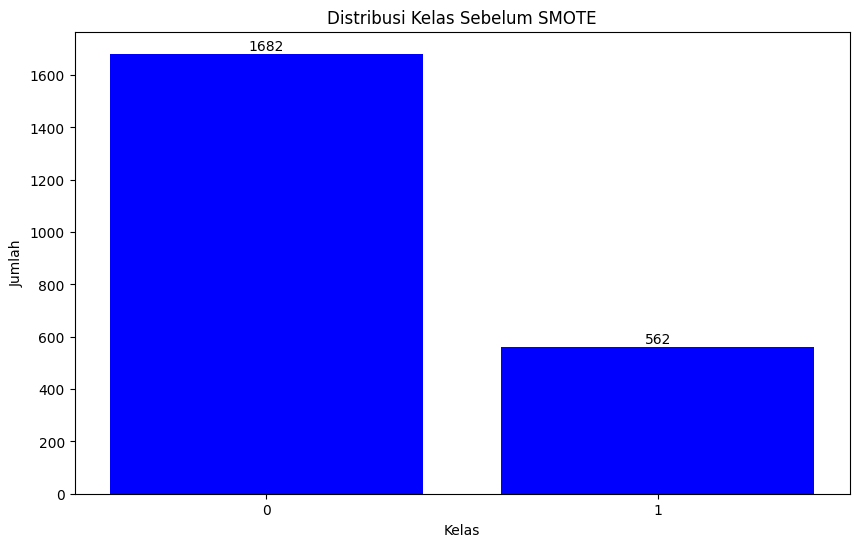

Jumlah distribusi kelas setelah SMOTE: Counter({0: 1682, 1: 1682})


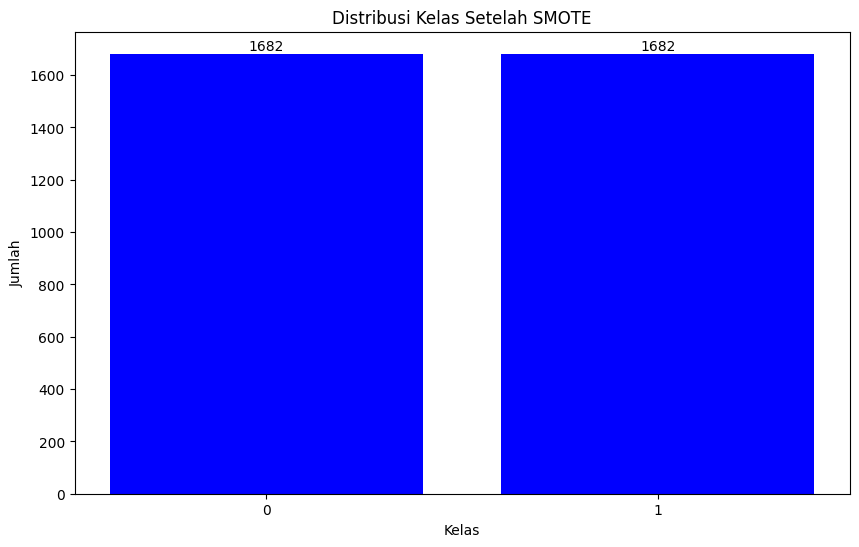

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt

def plot_class_distribution(y, title):
    counter = Counter(y)
    classes = list(counter.keys())
    counts = list(counter.values())

    plt.figure(figsize=(10, 6))
    bars = plt.bar(classes, counts, color='blue')
    plt.xlabel('Kelas')
    plt.ylabel('Jumlah')
    plt.title(title)
    plt.xticks([0, 1], ['0', '1'])  # Set x-ticks to be 0 and 1

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom')

    plt.show()

# Plot distribusi kelas sebelum SMOTE
print("Jumlah distribusi kelas sebelum SMOTE:", Counter(y_train))
plot_class_distribution(y_train, "Distribusi Kelas Sebelum SMOTE")

# Terapkan SMOTE pada data latih
smote = SMOTE(random_state=42)
X_train_tfidf_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

# Cetak jumlah distribusi kelas setelah SMOTE
print("Jumlah distribusi kelas setelah SMOTE:", Counter(y_train_smote))

# Plot distribusi kelas setelah SMOTE
plot_class_distribution(y_train_smote, "Distribusi Kelas Setelah SMOTE")


Model SVM dengan TF-IDF Setelah SMOTE

Akurasi Training: 0.9982164090368609
Akurasi Testing: 0.9162210338680927

              precision    recall  f1-score   support

           0       0.90      0.99      0.94       403
           1       0.97      0.73      0.83       158

    accuracy                           0.92       561
   macro avg       0.93      0.86      0.89       561
weighted avg       0.92      0.92      0.91       561


Confusion Matrix: [[399   4]
 [ 43 115]]

Accuracy: 0.9162210338680927
Model Prediction Accuracy: 91.62%

Precision: 0.9663865546218487
Recall: 0.7278481012658228
F1-Score: 0.8303249097472925



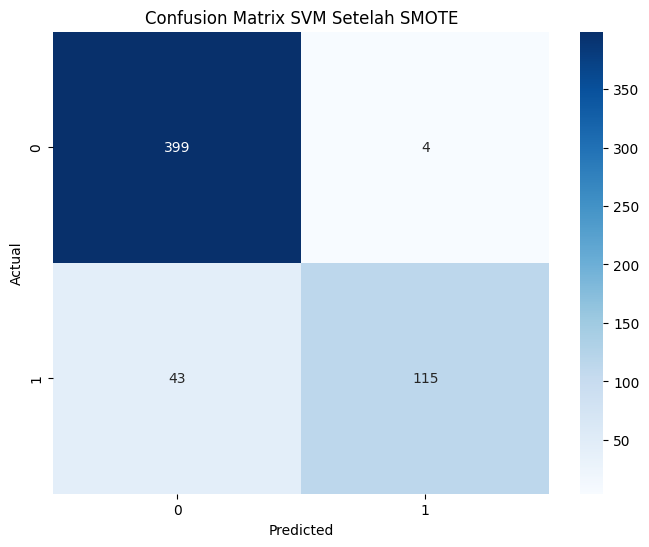

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Melatih model SVM dengan data yang sudah di-resample
svm_model_smote = SVC()
svm_model_smote.fit(X_train_tfidf_smote, y_train_smote)

# Memprediksi data uji
y_pred_svm_smote = svm_model_smote.predict(X_test_tfidf)

# Evaluasi model SVM setelah SMOTE
print("Model SVM dengan TF-IDF Setelah SMOTE")
print()
print(f"Akurasi Training: {svm_model_smote.score(X_train_tfidf_smote, y_train_smote)}")
print(f"Akurasi Testing: {svm_model_smote.score(X_test_tfidf, y_test)}")
print()
print(classification_report(y_test, y_pred_svm_smote))
print()
print('Confusion Matrix:', confusion_matrix(y_test, y_pred_svm_smote))
print()
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm_smote)}")
print('Model Prediction Accuracy:', str(np.round(accuracy_score(y_test, y_pred_svm_smote) * 100, 2)) + '%')
print()
print(f"Precision: {precision_score(y_test, y_pred_svm_smote)}")
print(f"Recall: {recall_score(y_test, y_pred_svm_smote)}")
print(f"F1-Score: {f1_score(y_test, y_pred_svm_smote)}")

def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

print()
plot_confusion_matrix(y_test, y_pred_svm_smote, [0, 1], 'Confusion Matrix SVM Setelah SMOTE')

Model GB dengan TF-IDF Setelah SMOTE

Akurasi Training: 0.9322235434007135
Akurasi Testing: 0.8449197860962567

              precision    recall  f1-score   support

           0       0.93      0.84      0.89       403
           1       0.68      0.85      0.75       158

    accuracy                           0.84       561
   macro avg       0.81      0.85      0.82       561
weighted avg       0.86      0.84      0.85       561


Confusion Matrix:
[[340  63]
 [ 24 134]]

Accuracy: 0.8449197860962567
Model Prediction Accuracy: 84.49%

Precision: 0.6802030456852792
Recall: 0.8481012658227848
F1-Score: 0.7549295774647887


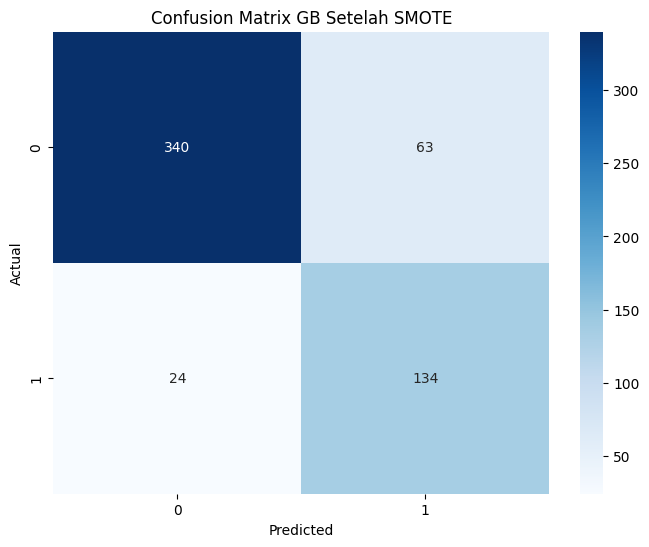

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Melatih model Gradient Boosting dengan data yang sudah di-resample
gb_model_smote = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)
gb_model_smote.fit(X_train_tfidf_smote, y_train_smote)

# Memprediksi data uji
y_pred_gb_smote = gb_model_smote.predict(X_test_tfidf)

# Evaluasi model Gradient Boosting setelah SMOTE
print("Model GB dengan TF-IDF Setelah SMOTE")
print()
print(f"Akurasi Training: {gb_model_smote.score(X_train_tfidf_smote, y_train_smote)}")
print(f"Akurasi Testing: {accuracy_score(y_test, y_pred_gb_smote)}")
print()
print(classification_report(y_test, y_pred_gb_smote))
print()
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_gb_smote))
print()
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb_smote)}")
print('Model Prediction Accuracy:', str(np.round(accuracy_score(y_test, y_pred_gb_smote) * 100, 2)) + '%')
print()
print(f"Precision: {precision_score(y_test, y_pred_gb_smote)}")
print(f"Recall: {recall_score(y_test, y_pred_gb_smote)}")
print(f"F1-Score: {f1_score(y_test, y_pred_gb_smote)}")

def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test, y_pred_gb_smote, [0, 1], 'Confusion Matrix GB Setelah SMOTE')

Best parameters for SVM: {'C': 18.778236783240246}
Best cross-validation score for SVM: 0.9325244993985707
Model SVM dengan TF-IDF Tuning Setelah SMOTE

Akurasi Training: 0.9325244993985707
Akurasi Testing: 0.8734402852049911

              precision    recall  f1-score   support

           0       0.94      0.88      0.91       403
           1       0.74      0.85      0.79       158

    accuracy                           0.87       561
   macro avg       0.84      0.87      0.85       561
weighted avg       0.88      0.87      0.88       561


Confusion Matrix: [[356  47]
 [ 24 134]]

Accuracy: 0.8734402852049911
Model Prediction Accuracy: 87.34%

Precision: 0.7403314917127072
Recall: 0.8481012658227848
F1-Score: 0.7905604719764011


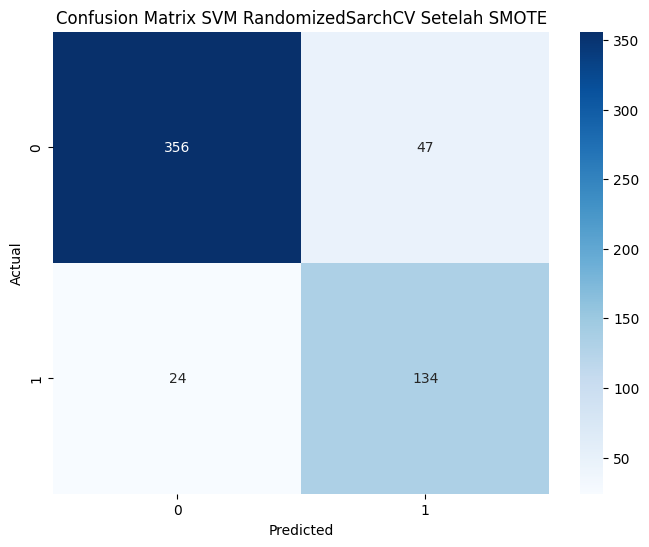

In [ ]:
# Inisialisasi model SVM
svm_model_smote_pipe = SVC(kernel='linear', probability=True)

# Parameter untuk Randomized Search
param_dist_svm = {'C': uniform(0.01, 1000)}

# Randomized Search untuk SVM
random_search_svm_smote = RandomizedSearchCV(svm_model_smote_pipe, param_distributions=param_dist_svm, n_iter=50, cv=5)
random_search_svm_smote.fit(X_train_tfidf_smote, y_train_smote)

print("Best parameters for SVM:", random_search_svm_smote.best_params_)
print("Best cross-validation score for SVM:", random_search_svm_smote.best_score_)

# Prediksi dan evaluasi SVM
y_pred_randomize_svm_smote = random_search_svm_smote.predict(X_test_tfidf)

# Evaluation
print("Model SVM dengan TF-IDF Tuning Setelah SMOTE")
print()
print(f"Akurasi Training: {random_search_svm_smote.best_score_}")
print(f"Akurasi Testing: {accuracy_score(y_test, y_pred_randomize_svm_smote)}")
print()
print(classification_report(y_test, y_pred_randomize_svm_smote))
print()
print('Confusion Matrix:', confusion_matrix(y_test, y_pred_randomize_svm_smote))
print()
print(f"Accuracy: {accuracy_score(y_test, y_pred_randomize_svm_smote)}")
print('Model Prediction Accuracy:', str(np.round(accuracy_score(y_test, y_pred_randomize_svm_smote) * 100, 2)) + '%')
print()
print(f"Precision: {precision_score(y_test, y_pred_randomize_svm_smote)}")
print(f"Recall: {recall_score(y_test, y_pred_randomize_svm_smote)}")
print(f"F1-Score: {f1_score(y_test, y_pred_randomize_svm_smote)}")

def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test, y_pred_randomize_svm_smote, [0, 1], 'Confusion Matrix SVM RandomizedSarchCV Setelah SMOTE')

Best parameters for Gradient Boosting: {'learning_rate': 0.33320293202075524, 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 162}
Best cross-validation score for Gradient Boosting: 0.9259839559895282
Model GB dengan TF-IDF Tuning Dengan SMOTE

Akurasi Training: 0.9259839559895282
Akurasi Testing: 0.8805704099821747

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       403
           1       0.77      0.82      0.79       158

    accuracy                           0.88       561
   macro avg       0.85      0.86      0.85       561
weighted avg       0.88      0.88      0.88       561


Confusion Matrix:
[[365  38]
 [ 29 129]]

Accuracy: 0.8805704099821747
Model Prediction Accuracy: 88.06%

Precision: 0.7724550898203593
Recall: 0.8164556962025317
F1-Score: 0.7938461538461538


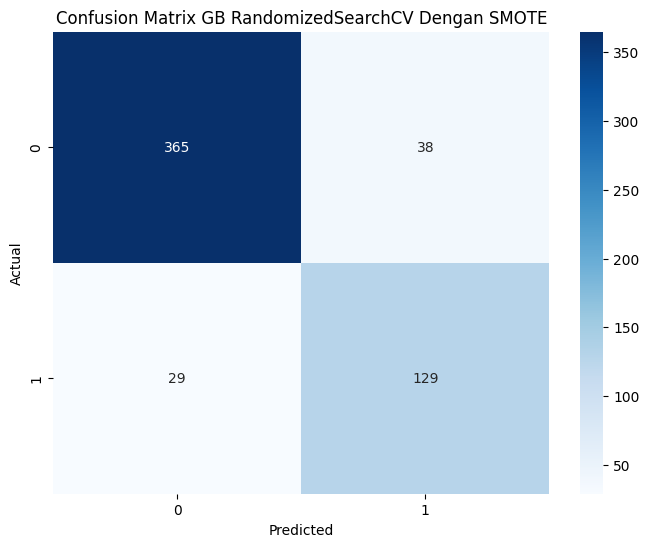

In [ ]:
# Inisialisasi model Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)

# Parameter untuk Randomized Search
param_dist_gb = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 1),
    'max_depth': randint(1, 5),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}

# Randomized Search untuk Gradient Boosting
random_search_gb_smote = RandomizedSearchCV(gb_model, param_distributions=param_dist_gb, n_iter=50, cv=5, random_state=42)
random_search_gb_smote.fit(X_train_tfidf_smote, y_train_smote)

print("Best parameters for Gradient Boosting:", random_search_gb_smote.best_params_)
print("Best cross-validation score for Gradient Boosting:", random_search_gb_smote.best_score_)

# Prediksi dan evaluasi Gradient Boosting
y_pred_random_gb_smote = random_search_gb_smote.predict(X_test_tfidf)

# Evaluation
print("Model GB dengan TF-IDF Tuning Dengan SMOTE")
print()
print(f"Akurasi Training: {random_search_gb_smote.best_score_}")
print(f"Akurasi Testing: {accuracy_score(y_test, y_pred_random_gb_smote)}")
print()
print(classification_report(y_test, y_pred_random_gb_smote))
print()
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_random_gb_smote))
print()
print(f"Accuracy: {accuracy_score(y_test, y_pred_random_gb_smote)}")
print('Model Prediction Accuracy:', str(np.round(accuracy_score(y_test, y_pred_random_gb_smote) * 100, 2)) + '%')
print()
print(f"Precision: {precision_score(y_test, y_pred_random_gb_smote)}")
print(f"Recall: {recall_score(y_test, y_pred_random_gb_smote)}")
print(f"F1-Score: {f1_score(y_test, y_pred_random_gb_smote)}")

def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test, y_pred_random_gb_smote, [0, 1], 'Confusion Matrix GB RandomizedSearchCV Dengan SMOTE')


In [ ]:
model_path = '/content/drive/MyDrive/ta_deteksi_hoax/model/svm_smote_randomize_model_hoax_detection.pkl'
joblib.dump(random_search_svm_smote, model_path)

['/content/drive/MyDrive/ta_deteksi_hoax/model/svm_smote_randomize_model_hoax_detection.pkl']

In [ ]:
model_path = '/content/drive/MyDrive/ta_deteksi_hoax/model/gb_smote_randomize_model_hoax_detection.pkl'
joblib.dump(random_search_gb_smote, model_path)

['/content/drive/MyDrive/ta_deteksi_hoax/model/gb_smote_randomize_model_hoax_detection.pkl']

In [ ]:
# Example new input text
def preprocess_and_extract_features(text, vectorizer):
    text = preprocess_text(text)
    text = text_process2(text)
    text_tfidf = vectorizer.transform([text])
    return text_tfidf

test_text2 = 'IKN akan ditinggalkan dan batal jadi ibukota.'
test_text2_tfidf = preprocess_and_extract_features(test_text2, vectorizer)

# Prediction and probability using the trained SVM model
prediction_svm = random_search_svm_smote.predict(test_text2_tfidf)
probability_svm = random_search_svm_smote.predict_proba(test_text2_tfidf)

print("Prediksi untuk teks baru dengan SVM:", "hoax" if prediction_svm[0] == 1 else "valid")
print(f"Probabilitas hoax: {probability_svm[0][1] * 100:.2f}%")
print(f"Probabilitas valid: {probability_svm[0][0] * 100:.2f}%")

# Prediction and probability using the trained Gradient Boosting model
prediction_gb = random_search_gb_smote.predict(test_text2_tfidf)
probability_gb = random_search_gb_smote.predict_proba(test_text2_tfidf)

print("Prediksi untuk teks baru dengan Gradient Boosting:", "hoax" if prediction_gb[0] == 1 else "valid")
print(f"Probabilitas hoax: {probability_gb[0][1] * 100:.2f}%")
print(f"Probabilitas valid: {probability_gb[0][0] * 100:.2f}%")

Prediksi untuk teks baru dengan SVM: hoax
Probabilitas hoax: 100.00%
Probabilitas valid: 0.00%
Prediksi untuk teks baru dengan Gradient Boosting: hoax
Probabilitas hoax: 51.27%
Probabilitas valid: 48.73%


In [ ]:
!pip install scikit-learn==1.2.2

  Using cached scikit_learn-1.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.6 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.1
    Uninstalling scikit-learn-1.5.1:
      Successfully uninstalled scikit-learn-1.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nlp-id 0.1.16.0 requires scikit-learn==1.5.1, but you have scikit-learn 1.2.2 which is incompatible.


In [ ]:
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)

# Load SVM model
svm_model_path = '/content/drive/MyDrive/ta_deteksi_hoax/model/svm_smote_randomize_model_hoax_detection.pkl'
loaded_svm_model = joblib.load(svm_model_path)

# Load Gradient Boosting model
gb_model_path = '/content/drive/MyDrive/ta_deteksi_hoax/model/gb_smote_randomize_model_hoax_detection.pkl'
loaded_gb_model = joblib.load(gb_model_path)


def preprocess_and_extract_features(text, vectorizer):
    text = preprocess_text(text)
    text = text_process2(text)
    text_tfidf = vectorizer.transform([text])
    return text_tfidf

test_text2 = 'IKN akan ditinggalkan dan batal jadi ibukota.'
test_text2_tfidf = preprocess_and_extract_features(test_text2, vectorizer)

# Prediction and probability using the loaded SVM model
prediction_svm = loaded_svm_model.predict(test_text2_tfidf)
probability_svm = loaded_svm_model.predict_proba(test_text2_tfidf)

print("Prediksi untuk teks baru dengan SVM:", "hoax" if prediction_svm[0] == 1 else "valid")
print(f"Probabilitas hoax: {probability_svm[0][1] * 100:.2f}%")
print(f"Probabilitas valid: {probability_svm[0][0] * 100:.2f}%")

# Prediction and probability using the loaded Gradient Boosting model
prediction_gb = loaded_gb_model.predict(test_text2_tfidf)
probability_gb = loaded_gb_model.predict_proba(test_text2_tfidf)

print("Prediksi untuk teks baru dengan Gradient Boosting:", "hoax" if prediction_gb[0] == 1 else "valid")
print(f"Probabilitas hoax: {probability_gb[0][1] * 100:.2f}%")
print(f"Probabilitas valid: {probability_gb[0][0] * 100:.2f}%")


In [ ]:
#Model SVM No SMOTE Randomize Search CV
def preprocess_and_extract_features(text, vectorizer):
    # Preprocessing
    text = preprocess_text(text)
    text = text_process2(text)

    # TF-IDF Vectorization
    text_tfidf = vectorizer.transform([text])

    return text_tfidf

# Contoh input test baru
test_text = 'Pembangunan IKN Nusantara di Kalimantan Timur hanya akal-akalan untuk mengeruk keuntungan pribadi para pejabat. Tidak ada rencana nyata untuk memindahkan ibu kota negara.'
test_text_tfidf = preprocess_and_extract_features(test_text, vectorizer)

# Prediksi menggunakan model yang telah dilatih
predict_svm_no_smote_randomize = svm_model.predict(test_text_tfidf)
print(predict_svm_no_smote_randomize)

In [ ]:
#Model SVM No SMOTE Randomize Search CV
def preprocess_and_extract_features(text, vectorizer):
    # Preprocessing
    text = preprocess_text(text)
    text = text_process2(text)

    # TF-IDF Vectorization
    text_tfidf = vectorizer.transform([text])

    return text_tfidf

# Contoh input test baru
test_text = 'Pembangunan IKN Nusantara di Kalimantan Timur hanya akal-akalan untuk mengeruk keuntungan pribadi para pejabat. Tidak ada rencana nyata untuk memindahkan ibu kota negara.'
test_text_tfidf = preprocess_and_extract_features(test_text, vectorizer)

# Prediksi menggunakan model yang telah dilatih
predict_gb_no_smote_randomize = gb_model.predict(test_text_tfidf)
print(predict_gb_no_smote_randomize)

In [ ]:
#Model SVM Randomize Search CV No SMOTE
def preprocess_and_extract_features(text, vectorizer):
    # Preprocessing
    text = preprocess_text(text)
    text = text_process2(text)

    # TF-IDF Vectorization
    text_tfidf = vectorizer.transform([text])

    return text_tfidf

# Contoh input test baru
test_text = 'Pembangunan IKN Nusantara di Kalimantan Timur hanya akal-akalan untuk mengeruk keuntungan pribadi para pejabat. Tidak ada rencana nyata untuk memindahkan ibu kota negara.'
test_text_tfidf = preprocess_and_extract_features(test_text, vectorizer)

# Prediksi menggunakan model yang telah dilatih
predict_svm_randomize_no_smote = random_search_svm.predict(test_text_tfidf)
print(predict_svm_randomize_no_smote)

In [ ]:
#Model GB Randomize Search CV No SMOTE
def preprocess_and_extract_features(text, vectorizer):
    # Preprocessing
    text = preprocess_text(text)
    text = text_process2(text)

    # TF-IDF Vectorization
    text_tfidf = vectorizer.transform([text])

    return text_tfidf

# Contoh input test baru
test_text = 'Pembangunan IKN Nusantara di Kalimantan Timur hanya akal-akalan untuk mengeruk keuntungan pribadi para pejabat. Tidak ada rencana nyata untuk memindahkan ibu kota negara.'
test_text_tfidf = preprocess_and_extract_features(test_text, vectorizer)

# Prediksi menggunakan model yang telah dilatih
predict_gb_randomize_no_smote = random_search_gb.predict(test_text_tfidf)
print(predict_gb_randomize_no_smote)

In [ ]:
#Model SVM SMOTE No Randomize Search CV
def preprocess_and_extract_features(text, vectorizer):
    # Preprocessing
    text = preprocess_text(text)
    text = text_process2(text)

    # TF-IDF Vectorization
    text_tfidf = vectorizer.transform([text])

    return text_tfidf

# Contoh input test baru
test_text = 'Pembangunan IKN Nusantara di Kalimantan Timur hanya akal-akalan untuk mengeruk keuntungan pribadi para pejabat. Tidak ada rencana nyata untuk memindahkan ibu kota negara.'
test_text_tfidf = preprocess_and_extract_features(test_text, vectorizer)

# Prediksi menggunakan model yang telah dilatih
predict_svm_smote_no_randomize = svm_model_smote.predict(test_text_tfidf)
print(predict_svm_smote_no_randomize)

Teks: Pemerintah mengumumkan tahap awal pembangunan IKN Nusantara di Kalimantan Timur telah dimulai. Presiden menyatakan proyek ini akan menjadi pusat pemerintahan baru Indonesia yang modern dan berkelanjutan.
Prediksi: Fakta

Teks: Proyek IKN Nusantara ditunda tanpa batas waktu karena pemerintah kehabisan dana. Semua konstruksi dihentikan dan pekerja dipulangkan.
Prediksi: Fakta

Teks: Menteri PUPR memastikan bahwa pembangunan infrastruktur dasar di IKN Nusantara akan selesai sesuai jadwal. Proyek ini mencakup pembangunan jalan, jembatan, dan fasilitas dasar lainnya.
Prediksi: Fakta

Teks: Semua warga di sekitar lokasi IKN Nusantara dipaksa pindah tanpa kompensasi. Pemerintah tidak memberikan bantuan apapun kepada warga yang terdampak.
Prediksi: Fakta

Teks: Pemerintah menargetkan penggunaan energi terbarukan di IKN Nusantara untuk mendukung visi kota hijau dan ramah lingkungan. Ini termasuk penggunaan panel surya dan energi angin.
Prediksi: Fakta

Teks: Lokasi pembangunan IKN Nusanta

In [ ]:
#Model GB SMOTE No Randomize Search CV
def preprocess_and_extract_features(text, vectorizer):
    # Preprocessing
    text = preprocess_text(text)
    text = text_process2(text)

    # TF-IDF Vectorization
    text_tfidf = vectorizer.transform([text])

    return text_tfidf

# Contoh input test baru
test_text = 'Pembangunan IKN Nusantara di Kalimantan Timur hanya akal-akalan untuk mengeruk keuntungan pribadi para pejabat. Tidak ada rencana nyata untuk memindahkan ibu kota negara.'
test_text_tfidf = preprocess_and_extract_features(test_text, vectorizer)

# Prediksi menggunakan model yang telah dilatih
predict_gb_smote_no_randomize = gb_model_smote.predict(test_text_tfidf)
print(predict_gb_smote_no_randomize)

In [ ]:
#Model SVM SMOTE + Randomize Search CV
def preprocess_and_extract_features(text, vectorizer):
    # Preprocessing
    text = preprocess_text(text)
    text = text_process2(text)

    # TF-IDF Vectorization
    text_tfidf = vectorizer.transform([text])

    return text_tfidf

# Contoh input test baru
test_text = 'Pembangunan IKN Nusantara di Kalimantan Timur hanya akal-akalan untuk mengeruk keuntungan pribadi para pejabat. Tidak ada rencana nyata untuk memindahkan ibu kota negara.'
test_text_tfidf = preprocess_and_extract_features(test_text, vectorizer)

# Prediksi menggunakan model yang telah dilatih
predict_svm_smote_randomize = random_search_svm_smote.predict(test_text_tfidf)
print(predict_svm_smote_randomize)

In [ ]:
# Function to preprocess and extract features for a new text input
def preprocess_and_extract_features(text, fitted_vectorizer):
    # Preprocessing
    text = preprocess_text(text)
    text = text_process2(text)
    # TF-IDF Vectorization
    text_tfidf = fitted_vectorizer.transform([text])
    return text_tfidf

# Example new input text
test_text = 'Pembangunan IKN Nusantara di Kalimantan Timur hanya akal-akalan untuk mengeruk keuntungan pribadi para pejabat. Tidak ada rencana nyata untuk memindahkan ibu kota negara.'
test_text_tfidf = preprocess_and_extract_features(test_text, vectorizer)

# Prediction using the trained model
predict_gb_smote_no_randomize = random_search_gb_smote.predict(test_text_tfidf)
print(predict_gb_smote_no_randomize)

[0]
